We will use TimeSeriesSplit to create the Cross validation datasets and then set out a 30% test set aside to test our model predictions with reality. 

Time Series cross-validator:  Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [10]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit # you have everything done for you
from sklearn.preprocessing import StandardScaler

import cvxopt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

import nbconvert

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()    


def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train, y_train, X_test, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
def prepareData(series, lag_start, lag_end, test_size):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

def runLassoCVonManager(data, y_col, test_size):  
    tscv = TimeSeriesSplit(n_splits=5)
    # train-test split
    y = data.dropna()[y_col]
    X = data.dropna().drop([y_col], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lasso = LassoCV(alphas = [0,.001,.01,.1,.5,1,5,10], cv=tscv)
    lasso.fit(X_train_scaled, y_train)
    plotModelResults(lasso, 
                     X_train_scaled, y_train, 
                     X_test_scaled, y_test,
                     plot_intervals=True, plot_anomalies=True)
    plotCoefficients(lasso, X)
    
    return lasso

def runRidgeCVonManager(data, y_col, test_size):  
    tscv = TimeSeriesSplit(n_splits=5)
    # train-test split
    y = data.dropna()[y_col]
    X = data.dropna().drop([y_col], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ridge = RidgeCV(alphas = [0,.001,.01,.1,.5,1,5,10], cv=tscv)
    ridge.fit(X_train_scaled, y_train)
    plotModelResults(ridge, 
                     X_train_scaled, y_train, 
                     X_test_scaled, y_test,
                     plot_intervals=True, plot_anomalies=True)
    plotCoefficients(ridge, X)
    
    return ridge

%matplotlib inline


Lets load the monthly return data for all managers (hedge funds, equity, inflation and Fixed income). 
Since this data is missing for lot of managers, ideally we will use all managers to achieve proper diversification. And this will  result in small set of data (69 months to be exact). This will create models that might not have high predictive power.

In [3]:
data = pd.read_csv("data/returns.csv")
data.index = pd.to_datetime(data['Date'])
data = data.drop(["Date"], axis=1 )
data.head()
data.shape

(300, 24)

In [4]:
interesting_cols = data.columns

In [5]:
#returns = data[interesting_cols]
returns = data.sort_index().dropna()
returns

European Equity L/S_Manager 1_European Equity L/S_Manager 1  \
Date                                                                      
2013-04-30                                             0.0020             
2013-05-31                                             0.0394             
2013-06-30                                             0.0004             
2013-07-31                                             0.0313             
2013-08-31                                            -0.0336             
2013-09-30                                             0.0414             
2013-10-31                                             0.0176             
2013-11-30                                             0.0275             
2013-12-31                                             0.0277             
2014-01-31                                            -0.0302             
2014-02-28                                             0.0358             
2014-03-31                                            -0.0244             
2014-04-30                                            -0.0166             
2014-05-31                                             0.0263             
2014-06-30                                             0.0000             
2014-07-31                                            -0.0128             
2014-08-31                                             0.0257             
2014-09-30                                            -0.0002             
2014-10-31                                             0.0145             
2014-11-30                                             0.0215             
2014-12-31                                             0.0020             
2015-01-31                                             0.0082             
2015-02-28                                             0.0194             
2015-03-31                                             0.0092             
2015-04-30                                            -0.0124             
2015-05-31                                             0.0295             
2015-06-30                                            -0.0037             
2015-07-31                                             0.0482             
2015-08-31                                            -0.0192             
2015-09-30                                            -0.0138             
...                                                       ...             
2016-07-31                                             0.0315             
2016-08-31                                             0.0047             
2016-09-30                                             0.0089             
2016-10-31                                            -0.0137             
2016-11-30                                             0.0125             
2016-12-31                                             0.0104             
2017-01-31                                             0.0295             
2017-02-28                                             0.0174             
2017-03-31                                             0.0151             
2017-04-30                                             0.0318             
2017-05-31                                             0.0400             
2017-06-30                                            -0.0096             
2017-07-31                                             0.0366             
2017-08-31                                             0.0164             
2017-09-30                                            -0.0121             
2017-10-31                                             0.0245             
2017-11-30                                            -0.0110             
2017-12-31                                            -0.0145             
2018-01-31                                             0.0609             
2018-02-28                                            -0.0067             
2018-03-31                           

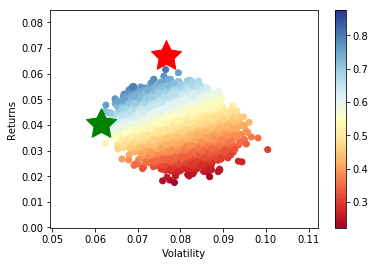

In [6]:
#calculate mean monthly return and covariance of monthly returns
mean_monthly_returns = returns.mean()
cov_matrix = returns.cov()
#set number of runs of random portfolio weights
num_portfolios = 25000

#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((3+len(interesting_cols),num_portfolios))

for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(len(interesting_cols)))
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_monthly_returns * weights) * 12
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(12)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

cols = ['ret','stdev','sharpe']
cols.extend(interesting_cols.tolist())
#convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=cols)

#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000)

Solve for the mean-variance optimized portfolio using quadratic programming and cvxopt

0.07241821818183 0.04712197464255258


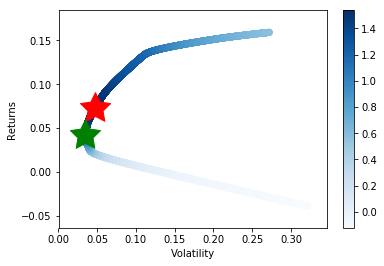

In [11]:
#calculate mean monthly return and covariance of monthly returnsmean_monthly_returns = returns.mean()
mean_monthly_returns = np.array(data.mean(axis=0))
cov_matrix = data.cov()

numcols = data.shape[1]

#set number of returns to minimize variance for
num_portfolios = 10000

max_return = max(mean_monthly_returns)
min_return = min(mean_monthly_returns)

return_vec = np.arange(min_return,max_return,(max_return-min_return)/num_portfolios)

#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((3+numcols,num_portfolios))

for i in range(num_portfolios):
    
    #get current return target
    r = return_vec[i]
    
    #set up values to put into solver
    P = matrix(np.array((cov_matrix)))
    q = matrix(np.zeros([numcols,1]))
    G = matrix(-np.identity(numcols))
    h = matrix(np.zeros([numcols,1]))
    A = matrix(np.vstack((np.ones([1,numcols]),matrix(mean_monthly_returns).T)))
    b = matrix([[1.0,r]])
    
    #use cvxopt to solve for minimum variance at given return level
    weights = solvers.qp(P,q,G,h,A,b)['x']

    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_monthly_returns * weights.T) * 12
    portfolio_std_dev = np.sqrt(weights.T*P*weights) * np.sqrt(12)

    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

cols = ['ret','stdev','sharpe']
#addcols = interesting_cols.tolist()
#cols.extend(addcols[0:])
cols.extend(data.columns.tolist())

#convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=cols)

#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='Blues')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000)
print(max_sharpe_port[0],max_sharpe_port[1])

As the QP gives a better portfolio  lets use that to  create proforma returns and then predict them in future. 

In [17]:
WeightedReturns = returns.mul( max_sharpe_port[3:], axis =1 )
WeightedReturns.sum(axis=1)
returns['Portfolio'] = WeightedReturns.sum(axis=1)

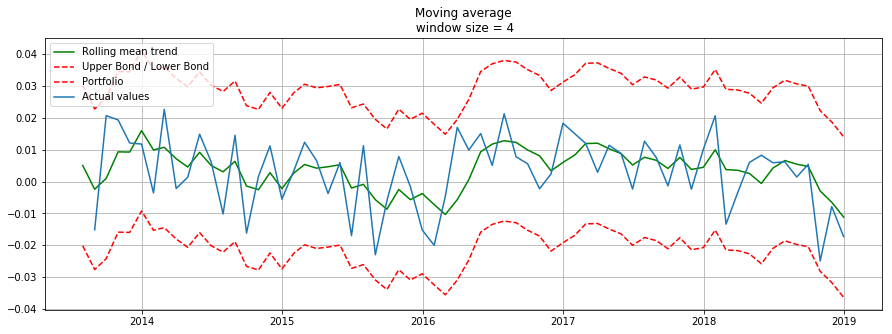

In [18]:
plotMovingAverage(returns['Portfolio'], 4, plot_intervals=True)

If we would have invested in this portfolio,  the total return till now would be like this

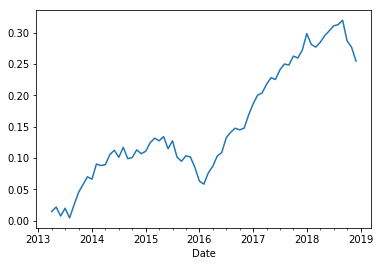

In [19]:
# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+returns["Portfolio"]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

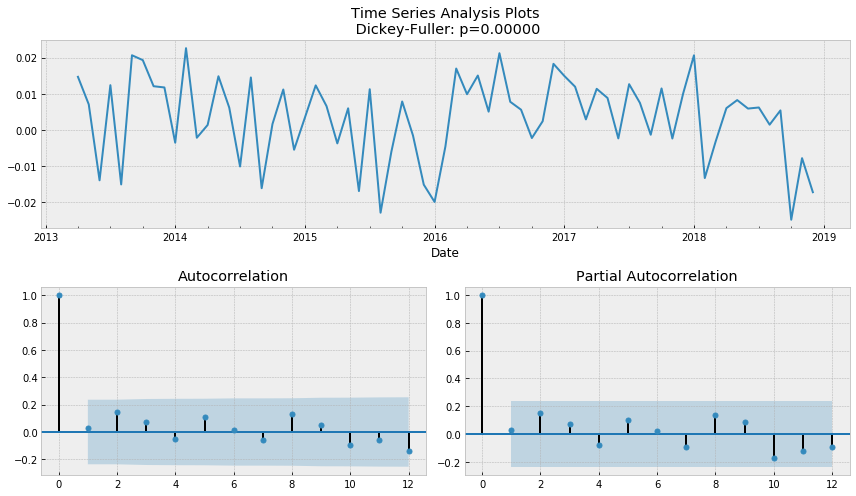

In [20]:
tsplot( returns["Portfolio"], lags=12)

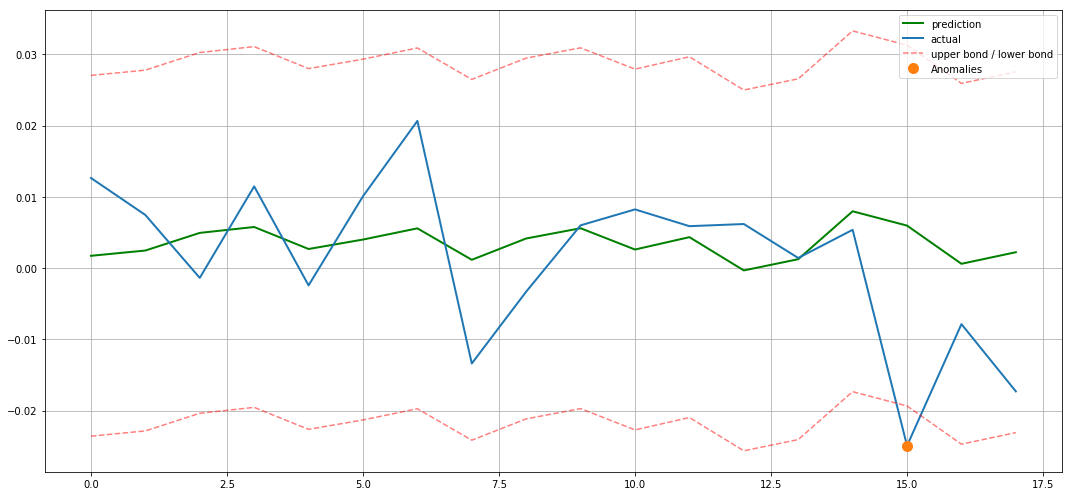

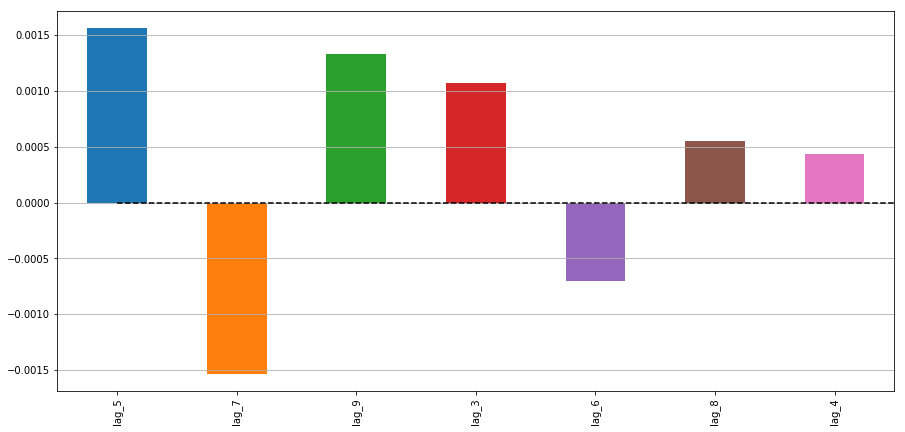

In [21]:
X_train, X_test, y_train, y_test = prepareData(returns["Portfolio"], lag_start=3, lag_end=10, test_size=0.3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train_scaled, y_train, X_test_scaled, y_test, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr, X_train)

Before using Time Series forecasting lets see if the lags are correlated, and if we have to adjust for autocorrelation

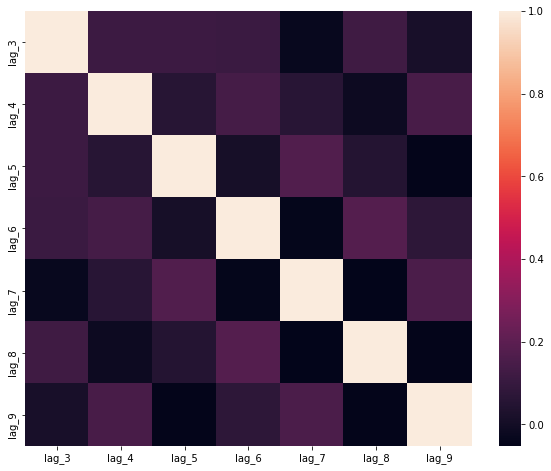

In [23]:
#before using Time Series forecasting lets see if the lags are correlated
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

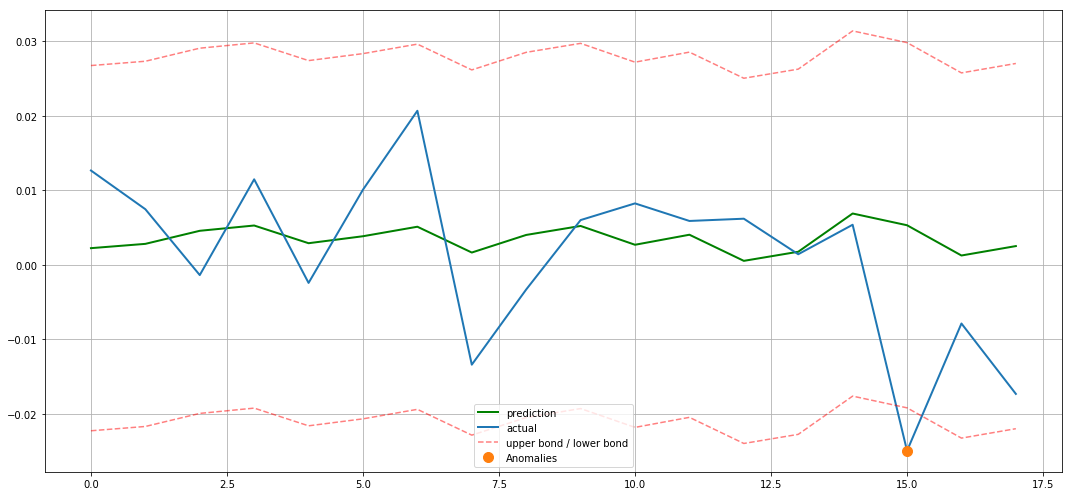

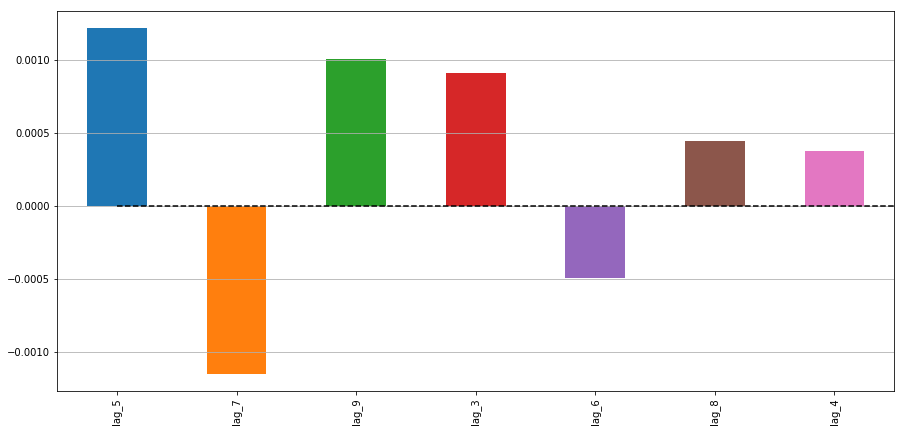

In [24]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train_scaled, y_train,
                 X_test_scaled, y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge, X_train)

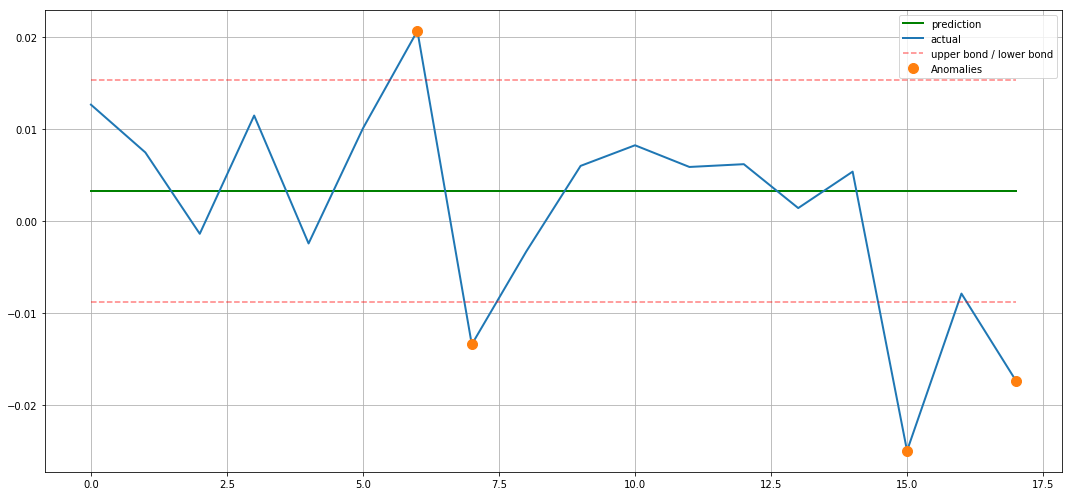

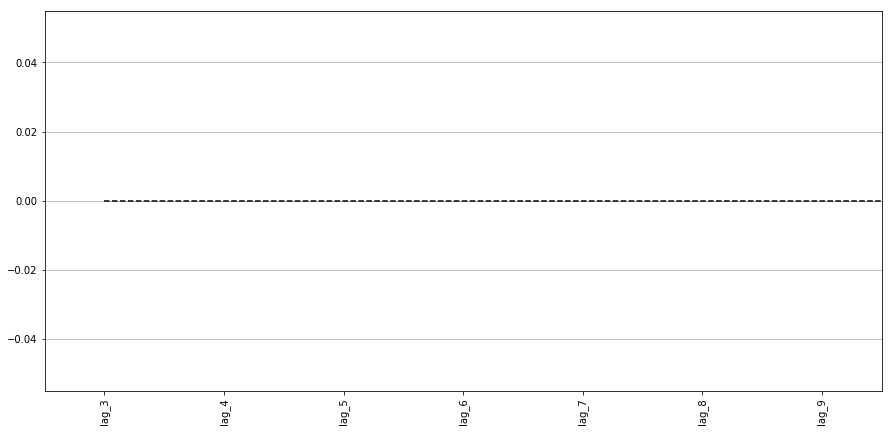

In [25]:
lasso = LassoCV(cv=tscv, alphas = [0,.001,.01,.1,.5,1,5,10] )
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train_scaled, y_train,
                 X_test_scaled, y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso, X_train)

As we can see above, Lasso unfortunately doesnt converge for such a small dataset. 

In [26]:
#now lets train using SARIMA


# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


36

In [27]:
def optimizeSARIMA(ret, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ret, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [28]:
%%time
result_table = optimizeSARIMA(returns["Portfolio"], parameters_list, d, D, s)


Wall time: 22.1 s


In [29]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(returns["Portfolio"], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Portfolio   No. Observations:                   69
Model:             SARIMAX(2, 1, 4)x(0, 1, 0, 24)   Log Likelihood                 122.457
Date:                            Tue, 19 Mar 2019   AIC                           -230.915
Time:                                    22:13:05   BIC                           -218.425
Sample:                                04-30-2013   HQIC                          -226.283
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1674      0.338      0.495      0.620      -0.495       0.830
ar.L2         -0.9432      0.181   

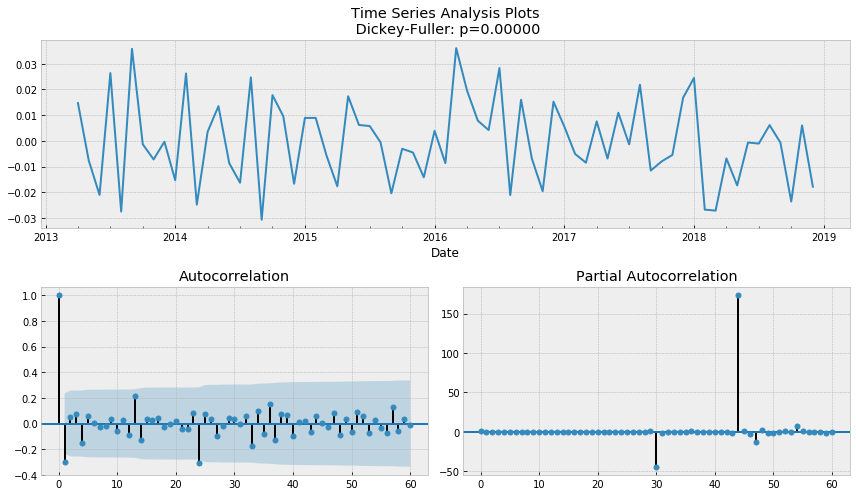

In [30]:
tsplot(best_model.resid, lags=60)

In [31]:
def plotSARIMA(se, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = se.copy()
    data = data.to_frame()
    data.columns = ['original']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:25] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['original'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.original, label="original")
    plt.legend()
    plt.grid(True);

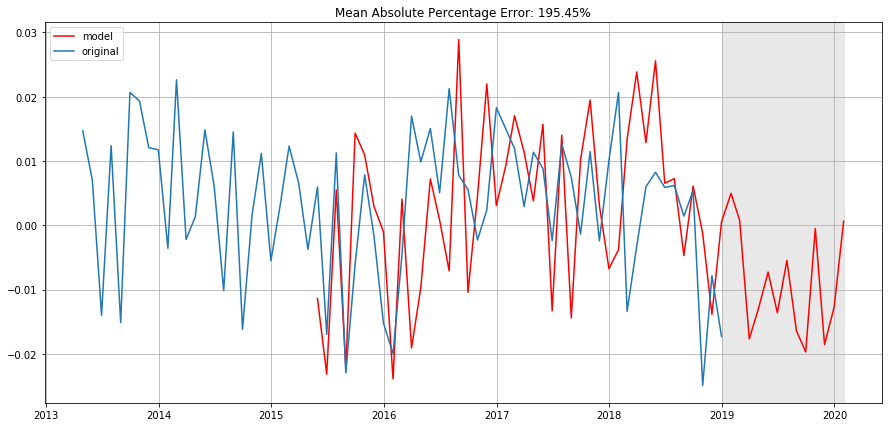

In [32]:
plotSARIMA(returns["Portfolio"], best_model, 12)

# Manager Level Factor Analysis using Daily returns
Lets regress the manager returns for EQuity managers against AQR data and Fixed Income managers against curve and hyig data. 

This analysis will  be done using RidgeCV as it provides inbuilt multifold cross validation, instead of doing simple cross validation by holding out a validation set.


In [29]:
##Create the AQR daily dataset and save it for future use
SMB = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="SMB", index_col=0)
HML = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="HML_Devil", index_col=0)
UMD = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="UMD", index_col=0)
RF = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="RF", index_col=0)
MKT = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="MKT", index_col=0)
BAB = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="BAB", index_col=0)
QMJ = pd.read_excel("data/AQR_USA_daily.xlsx", sheet_name="QMJ", index_col=0)
AQR = pd.concat([SMB,HML,UMD,RF,MKT,BAB,QMJ],1)
AQR.index = pd.to_datetime(AQR.index)
AQR = AQR.sort_index()
AQR.shape,HML.shape,SMB.shape,UMD.shape,RF.shape,MKT.shape,BAB.shape,QMJ.shape
AQR.to_csv("data/AQR_combined.csv",index_label ="Date")

In [44]:
AQR.head()

SMB  HML_Devil  UMD  RF       MKT  BAB  QMJ
1926-07-01 -0.001134  -0.002133  NaN NaN  0.000977  NaN  NaN
1926-07-02 -0.003693   0.002451  NaN NaN  0.004409  NaN  NaN
1926-07-05  0.000000   0.000000  NaN NaN  0.000000  NaN  NaN
1926-07-06 -0.001413  -0.006113  NaN NaN  0.001797  NaN  NaN
1926-07-07 -0.001661  -0.003518  NaN NaN  0.000836  NaN  NaN

In [210]:
aqr = pd.read_csv("data/AQR_combined.csv", index_col = "Date")
aqr.index = pd.to_datetime(aqr.index)
aqr = aqr.sort_index()
aqr.head()

SMB  HML_Devil  UMD  RF       MKT  BAB  QMJ
Date                                                        
1926-07-01 -0.001134  -0.002133  NaN NaN  0.000977  NaN  NaN
1926-07-02 -0.003693   0.002451  NaN NaN  0.004409  NaN  NaN
1926-07-05  0.000000   0.000000  NaN NaN  0.000000  NaN  NaN
1926-07-06 -0.001413  -0.006113  NaN NaN  0.001797  NaN  NaN
1926-07-07 -0.001661  -0.003518  NaN NaN  0.000836  NaN  NaN

In [211]:
hyig = pd.read_csv("data/bench_daily.csv", index_col = "Date")
curve = pd.read_csv("data/yield_curve_daily.csv", index_col = "Date")
managers = pd.read_csv("data/returns_managers_daily.csv", index_col = "Date")
managers.shape , curve.shape, hyig.shape

In [215]:
fi_X_cols = hyig.columns.to_list()
fi_X_cols.extend( curve.columns.to_list() )
fi_X_cols 

['Bloomberg Barclays US Liquid Investment Grade',
 'ML High Yield',
 'h15t1m',
 'h15t3m',
 'h15t6m',
 'h15t1y',
 'h15t2y',
 'h15t3y',
 'h15t5y',
 'h15t7y',
 'h15t10y',
 'h15t20y',
 'h15t30y']

## Fixed income factors 
Here we will use dimension decomposition (using PCA) as well as create a non decomposed factors for regression. 
Non Decomposed factors help in explainabilty of the regression and easy attribution of managers performance against FI factors.

In [217]:
fi_factors_nonPCA = pd.concat([hyig,curve],1)

In [263]:
fi_factors_nonPCA.index= pd.to_datetime(fi_factors_nonPCA.index)
fi_factors_nonPCA = fi_factors_nonPCA.dropna().sort_index()
fi_factors_nonPCA.dropna().head()

Bloomberg Barclays US Liquid Investment Grade  ML High Yield  \
Date                                                                       
2010-06-30                                       102.6497        717.467   
2010-07-30                                       105.2521        742.315   
2010-08-31                                       107.5635        743.489   
2010-09-30                                       108.5326        765.563   
2010-10-29                                       108.7736        783.884   

            h15t1m  h15t3m  h15t6m  h15t1y  h15t2y  h15t3y  h15t5y  h15t7y  \
Date                                                                         
2010-06-30    0.17    0.18    0.22    0.32    0.61    1.00    1.79    2.42   
2010-07-30    0.14    0.15    0.20    0.29    0.55    0.84    1.60    2.30   
2010-08-31    0.16    0.14    0.19    0.25    0.47    0.72    1.33    1.92   
2010-09-30    0.14    0.16    0.19    0.27    0.42    0.64    1.27    1.91   
2010-10-29    0.14    0.12    0.17    0.22    0.34    0.51    1.17    1.89   

            h15t10y  h15t20y  h15t30y  
Date                                   
2010-06-30     2.97     3.74     3.91  
2010-07-30     2.94     3.74     3.98  
2010-08-31     2.47     3.23     3.52  
2010-09-30     2.53     3.38     3.69  
2010-10-29     2.63     3.64     3.99

In [219]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
curve = curve.dropna()
pca.fit(curve)
pca_curve = pca.transform(curve)

In [220]:
pca_curve = pd.DataFrame(pca_curve, columns = ['shift','flattening','inversion'], index = curve.index)

In [221]:
#pca_curve.index  = pd.to_datetime(pca_curve.index)
pca_curve.head()

shift  flattening  inversion
Date                                      
7/31/2001  7.066279    1.523164   0.166059
8/1/2001   7.127785    1.577394   0.112832
8/2/2001   7.237217    1.675533   0.040677
8/3/2001   7.278547    1.721868   0.000352
8/6/2001   7.240134    1.723206   0.030990

In [222]:
fi_factors_PCA = pd.concat([hyig,pca_curve],1)
fi_factors_PCA.index= pd.to_datetime(fi_factors_PCA.index)
fi_factors_PCA = fi_factors_PCA.dropna().sort_index()
fi_factors_PCA.dropna().head()

Bloomberg Barclays US Liquid Investment Grade  ML High Yield  \
2010-06-30                                       102.6497        717.467   
2010-07-30                                       105.2521        742.315   
2010-08-31                                       107.5635        743.489   
2010-09-30                                       108.5326        765.563   
2010-10-29                                       108.7736        783.884   

               shift  flattening  inversion  
2010-06-30 -2.297701    1.014690   0.214745  
2010-07-30 -2.488180    0.993011   0.415213  
2010-08-31 -2.989990    0.171501   0.386554  
2010-09-30 -2.980894    0.339852   0.569150  
2010-10-29 -3.013334    0.663961   0.869186

In [223]:
managers.index = pd.to_datetime(managers.index)
managers = managers.pct_change()
managers.head()

EQ_Manager 8  EQ_Manager 9  EQ_Manager 10  EQ_Manager 11  \
Date                                                                   
1990-01-01           NaN           NaN            NaN            NaN   
1990-01-02           NaN           NaN            NaN            NaN   
1990-01-03           NaN           NaN            NaN            NaN   
1990-01-04           NaN           NaN            NaN            NaN   
1990-01-05           NaN           NaN            NaN            NaN   

            EQ_Manager A  EQ_Manager B  EQ_Manager C  EQ_Manager D  \
Date                                                                 
1990-01-01           NaN           NaN           NaN           NaN   
1990-01-02           NaN           NaN           NaN      0.018072   
1990-01-03           NaN           NaN      0.003122      0.000000   
1990-01-04           NaN           NaN     -0.004669     -0.005917   
1990-01-05           NaN           NaN     -0.006031     -0.005952   

            EQ_Manager E  EQ_Manager 18  ...  FI_Manager 22  FI+EQ_Manager 23  \
Date                                     ...                                    
1990-01-01           NaN            NaN  ...            NaN               NaN   
1990-01-02           NaN            NaN  ...            NaN               NaN   
1990-01-03           NaN            NaN  ...            NaN               NaN   
1990-01-04           NaN            NaN  ...            NaN               NaN   
1990-01-05           NaN            NaN  ...            NaN               NaN   

            FI_Manager 24  FI_Manager F  FI_Manager G  FI_Manager H  \
Date                                                                  
1990-01-01            NaN           NaN           NaN           NaN   
1990-01-02            NaN           NaN           NaN           NaN   
1990-01-03            NaN           NaN           NaN           NaN   
1990-01-04            NaN           NaN           NaN           NaN   
1990-01-05            NaN           NaN           NaN           NaN   

            FI_Manager I  FI_Manager J  FI_Manager K  Unnamed: 22  
Date                                                               
1990-01-01           NaN           NaN           NaN          NaN  
1990-01-02           NaN           NaN           NaN          NaN  
1990-01-03           NaN     -0.000937      0.028571          NaN  
1990-01-04           NaN      0.000938      0.000000          NaN  
1990-01-05           NaN     -0.000937      0.000000          NaN  

[5 rows x 22 columns]

In [224]:
eq_managers_cols = [ x for x in managers.columns if "EQ" in x ]
eq_managers = managers[eq_managers_cols]
fi_managers_cols = [ x for x in managers.columns if "FI" in x ]
fi_managers = managers[fi_managers_cols]

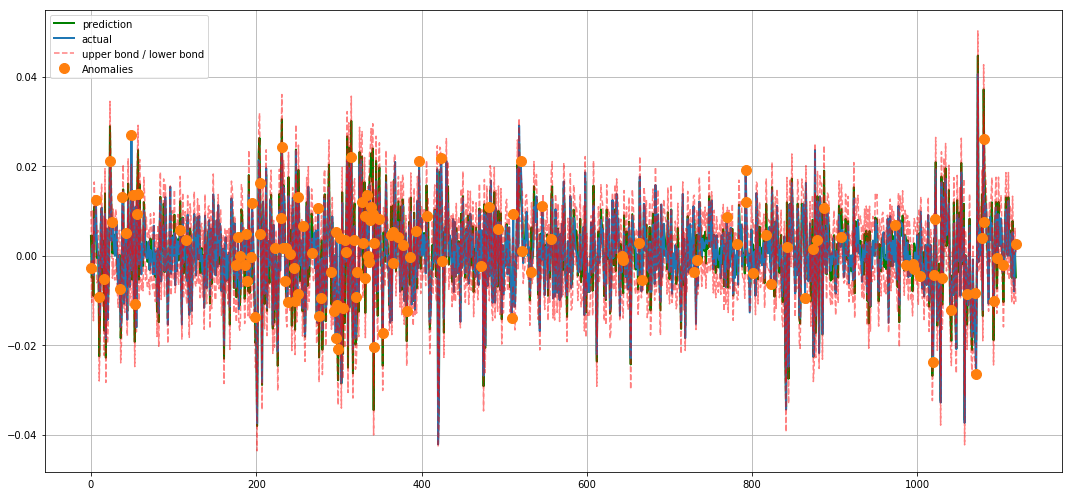

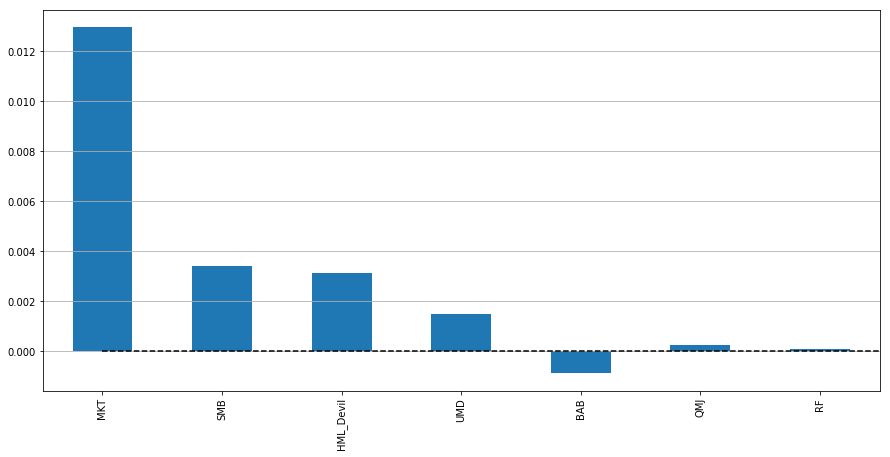

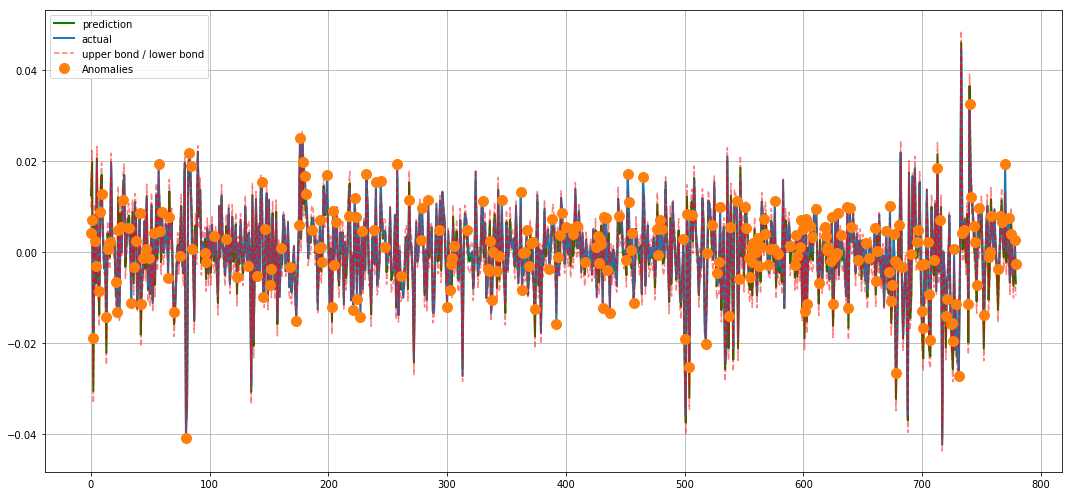

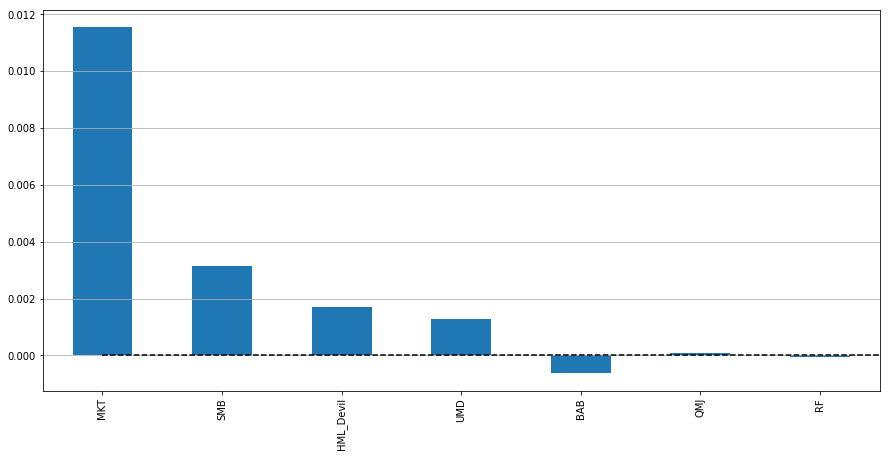

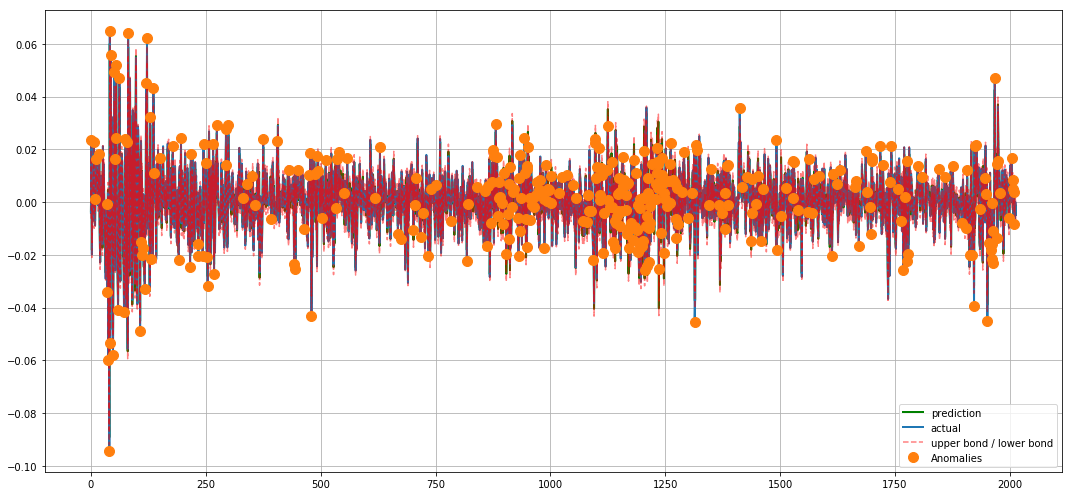

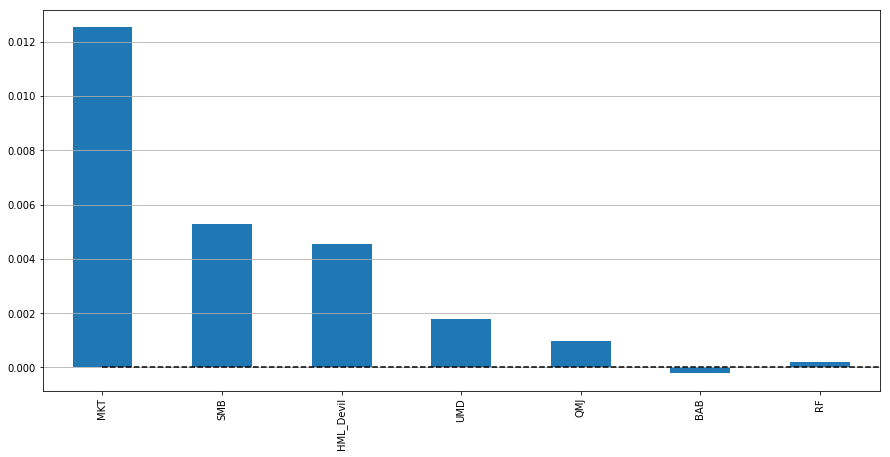

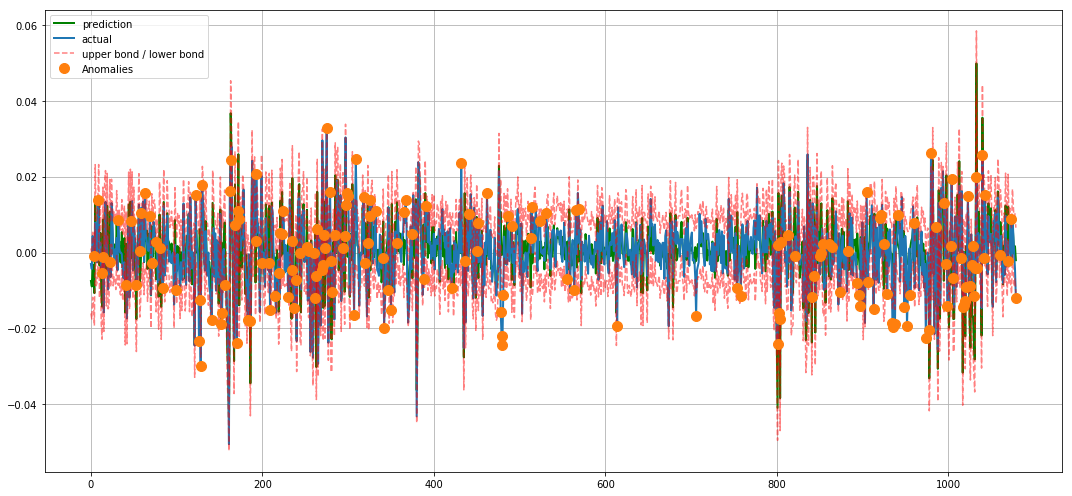

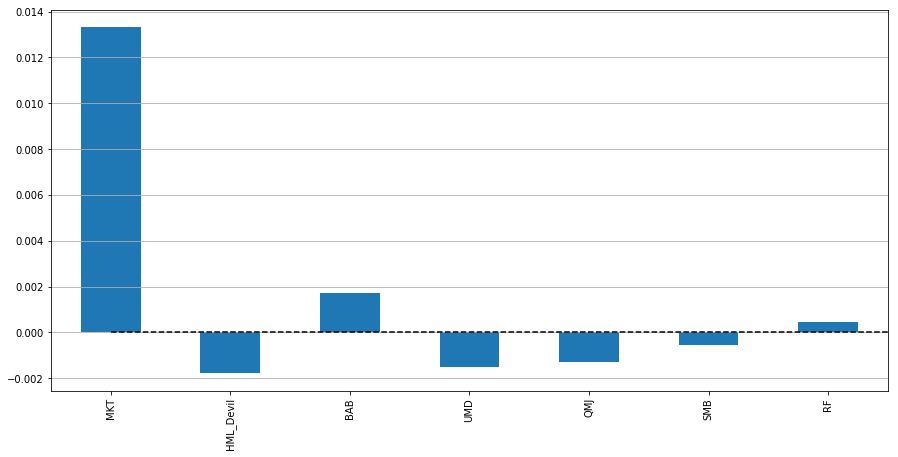

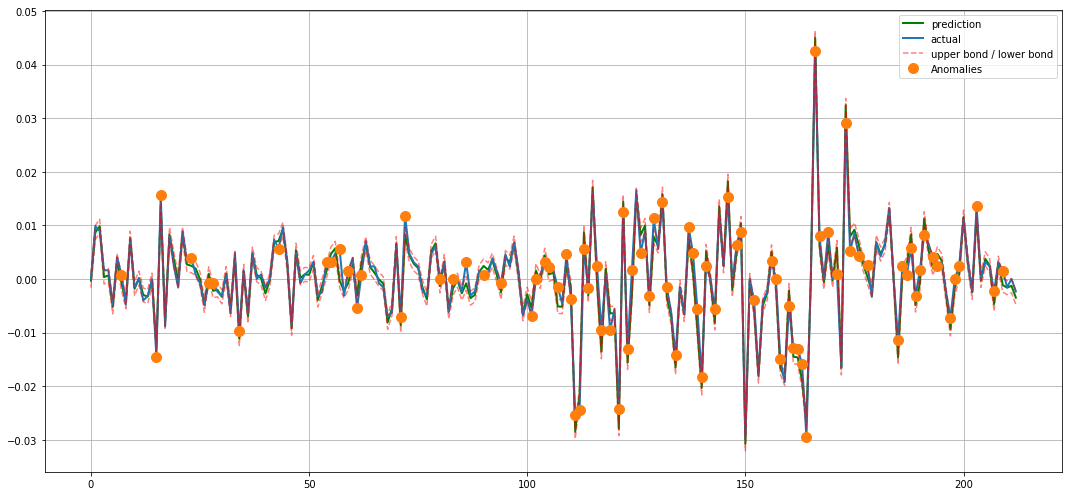

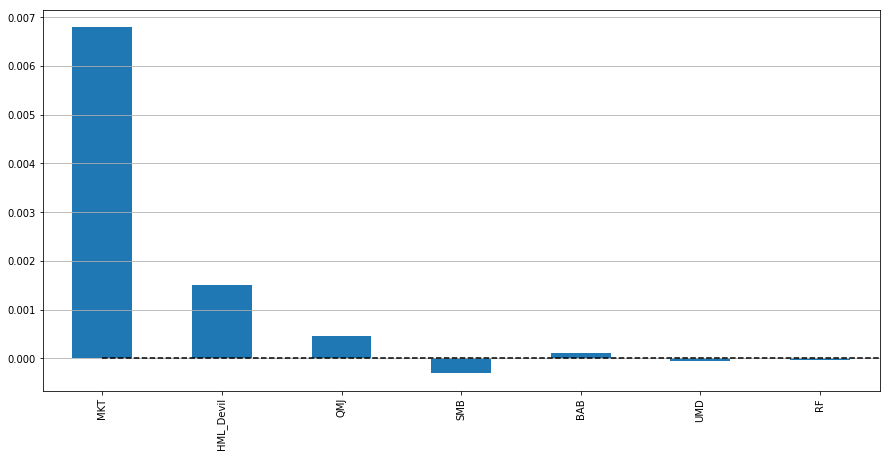

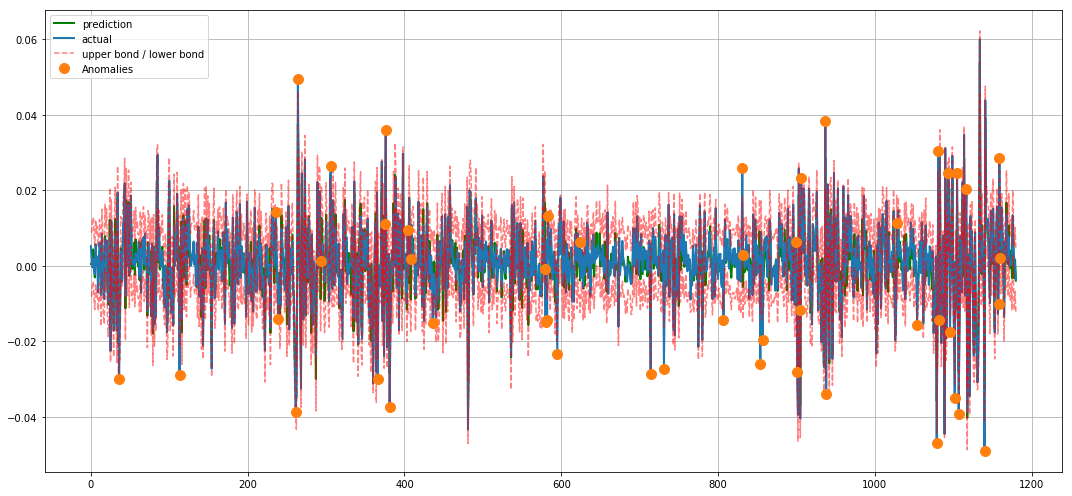

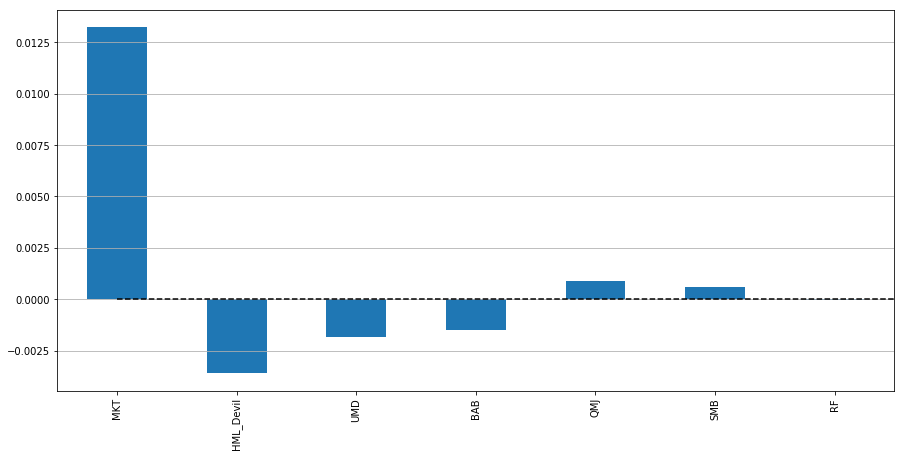

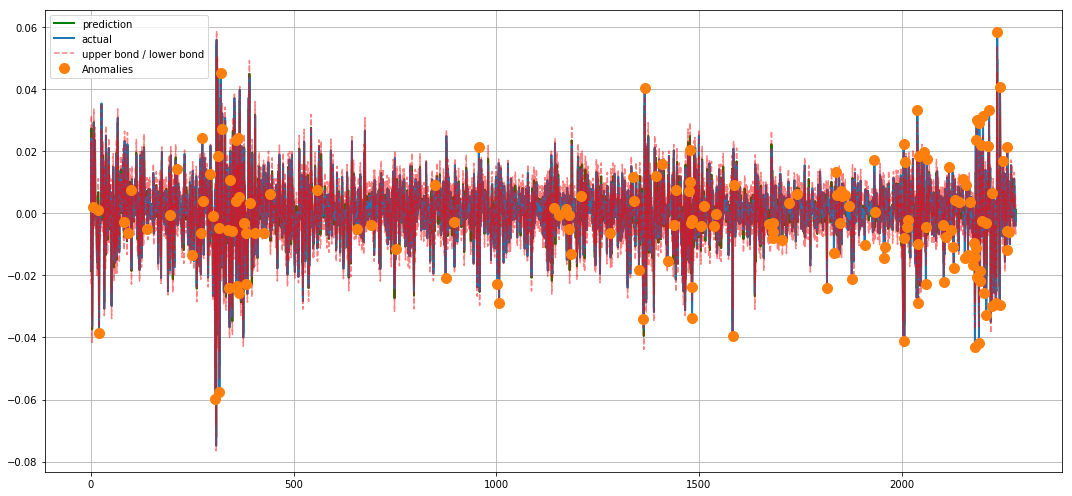

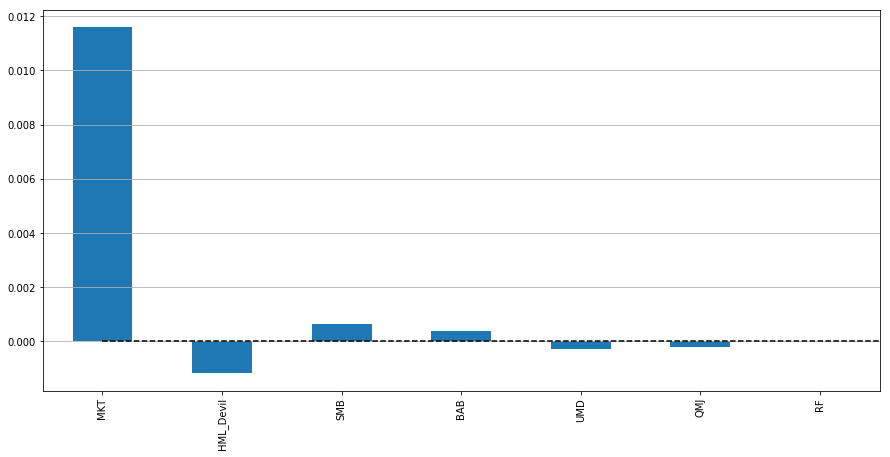

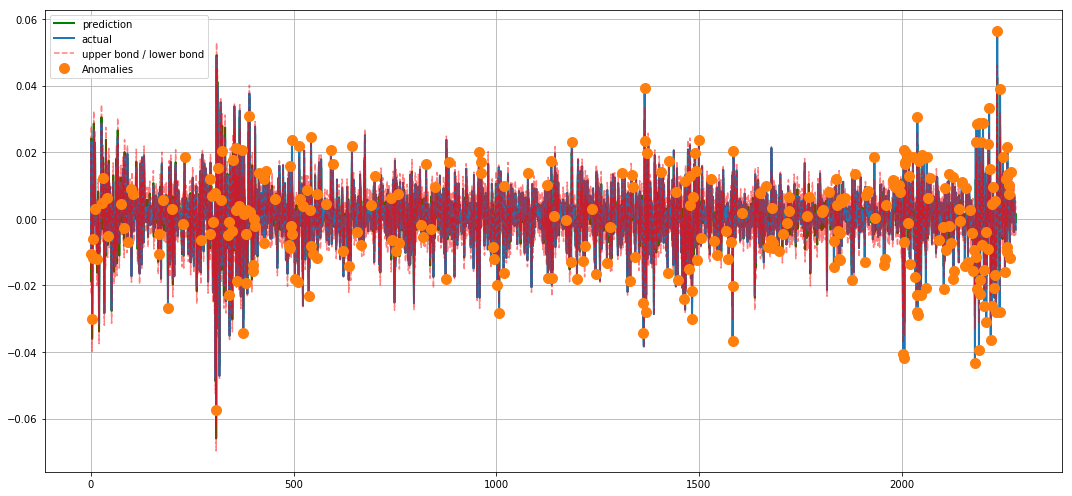

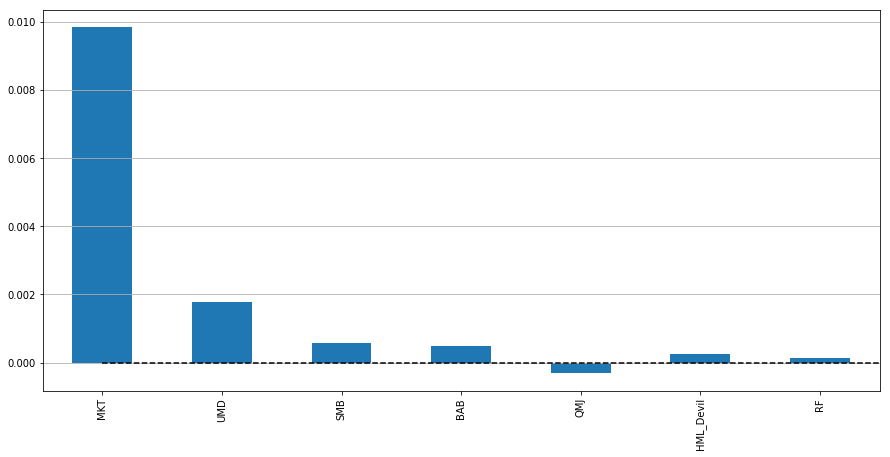

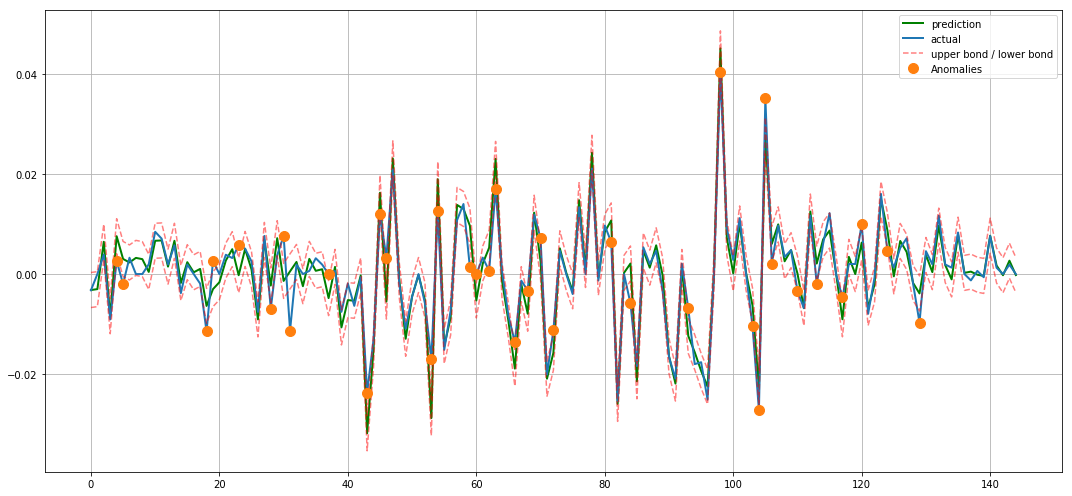

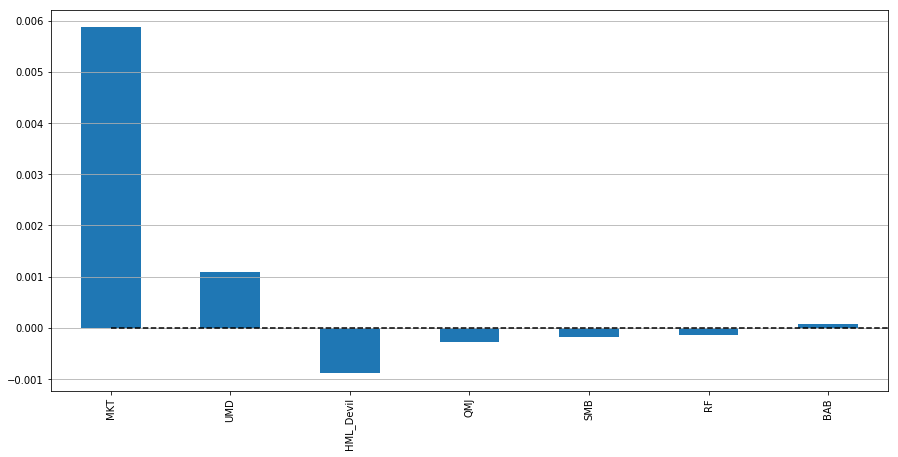

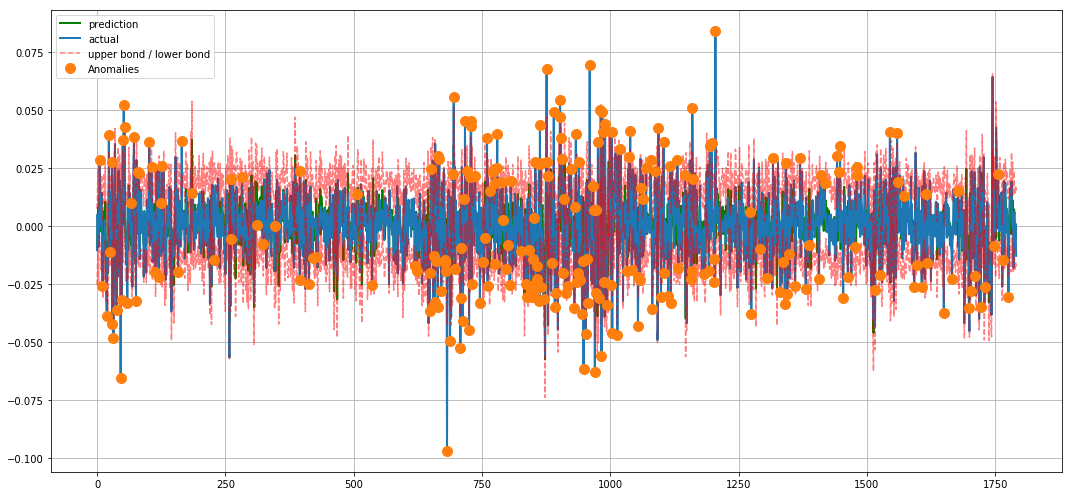

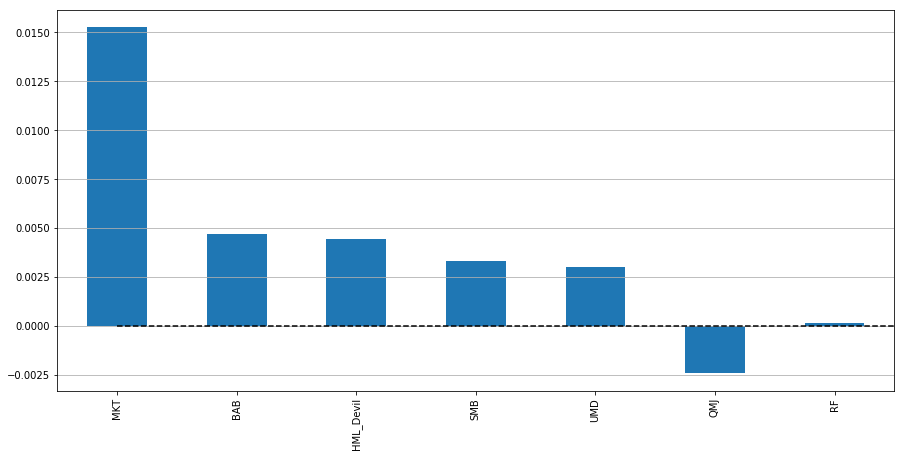

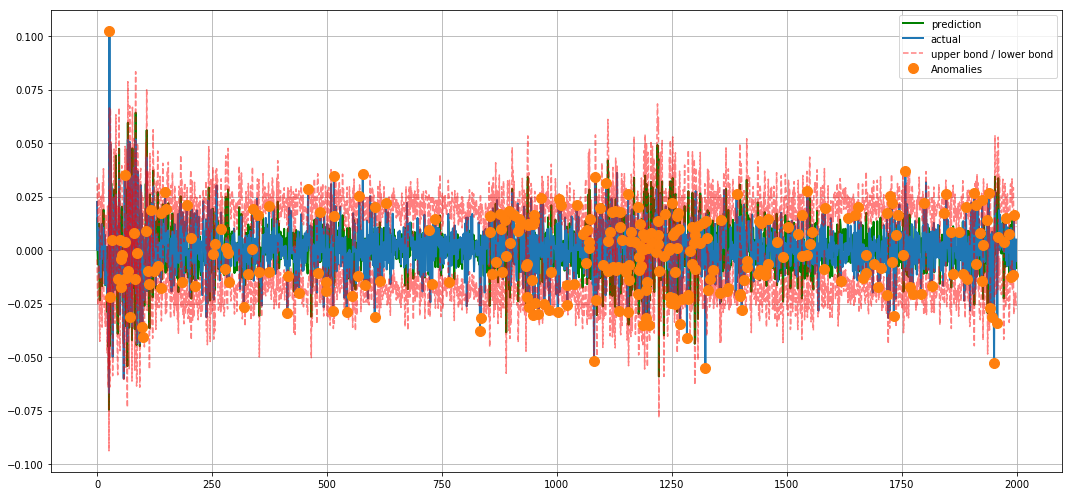

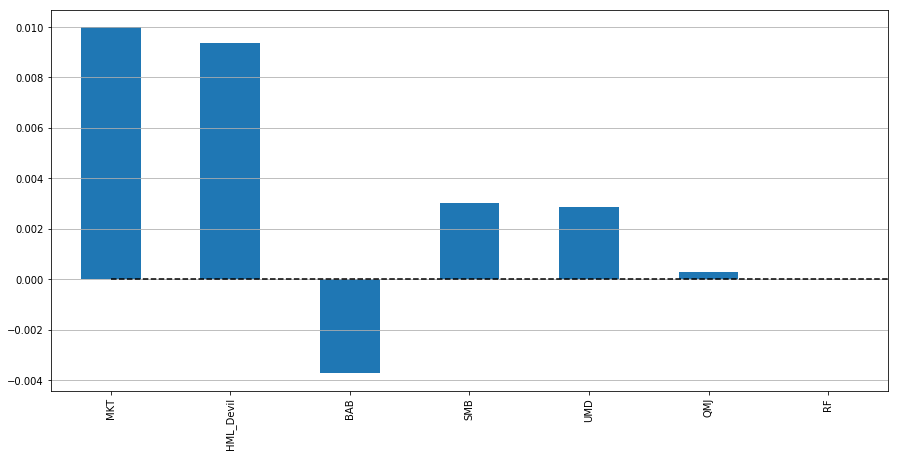

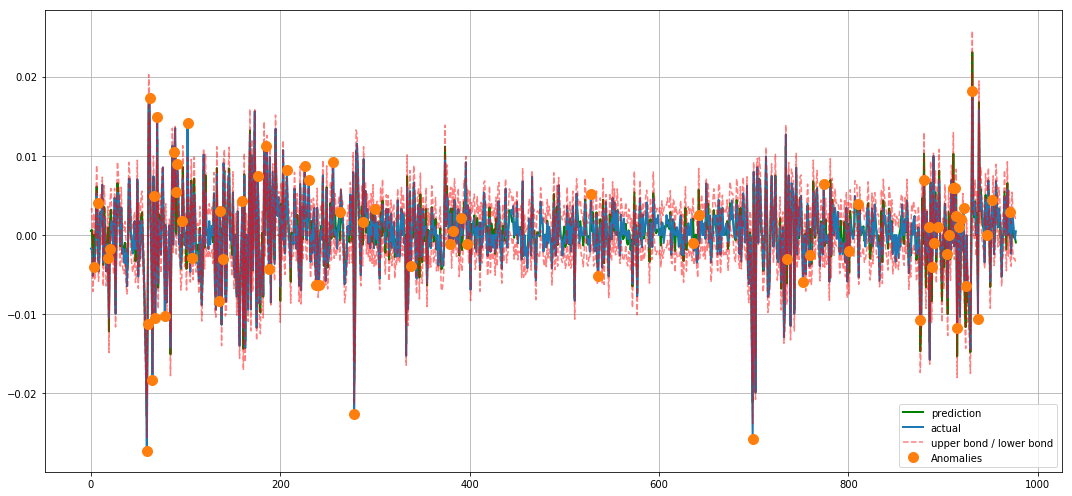

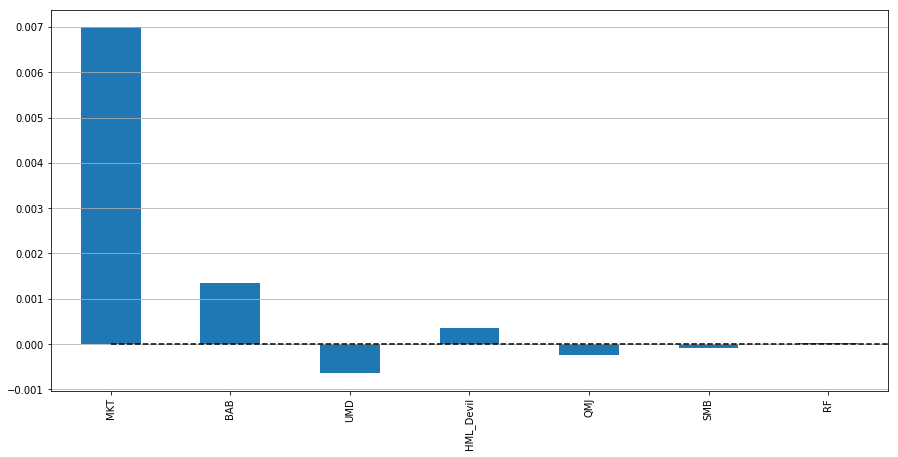

In [249]:
eq_data = pd.concat([aqr,eq_managers],1)
eq_models = []
test_size = 0.3
for y_col in eq_managers_cols: 
    x_cols = aqr.columns.to_list()
    x_cols.extend([y_col])
    data = eq_data[x_cols]
    eq_models.append( runRidgeCVonManager(data, y_col, test_size = test_size).coef_ )

In [250]:
eq_models_df = pd.DataFrame(np.row_stack(eq_models))
eq_models_df.columns = aqr.columns.to_list()
eq_models_df.index = eq_managers_cols
eq_models_df.head()

SMB  HML_Devil       UMD        RF       MKT       BAB  \
EQ_Manager 8   0.003398   0.003123  0.001469  0.000096  0.012957 -0.000892   
EQ_Manager 9   0.003151   0.001713  0.001266 -0.000061  0.011527 -0.000631   
EQ_Manager 10  0.005287   0.004552  0.001799  0.000187  0.012523 -0.000221   
EQ_Manager 11 -0.000530  -0.001788 -0.001513  0.000451  0.013308  0.001716   
EQ_Manager A  -0.000307   0.001500 -0.000051 -0.000029  0.006785  0.000118   

                    QMJ  
EQ_Manager 8   0.000254  
EQ_Manager 9   0.000092  
EQ_Manager 10  0.000970  
EQ_Manager 11 -0.001273  
EQ_Manager A   0.000454

### Equity Managers Attribution
Below plot shows how each equity manager performace is different and what causes that difference. We can see that EQ Managers 8, 9 and 10  are quite similar in return profile and they are quite different from EQ manager 20.

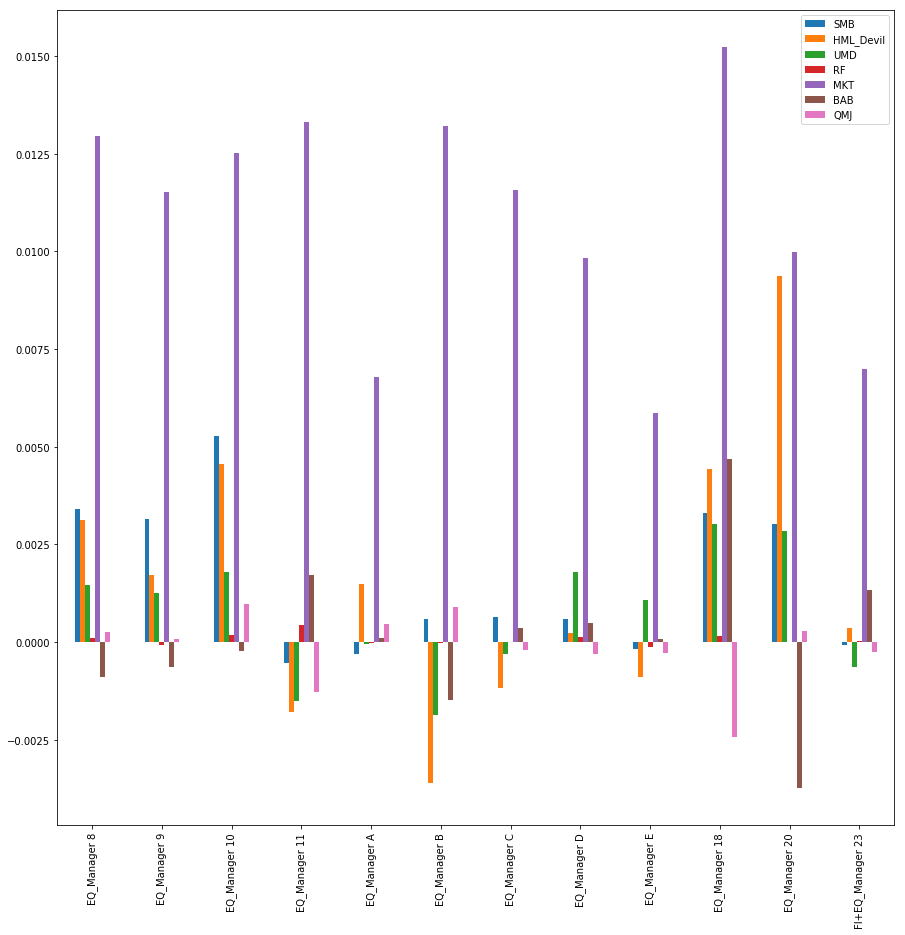

In [251]:
eq_models_df.plot.bar(figsize=(15,15))

### Equity Factor Significance 
Below plot what factors and in what magnitude contribute to the performance of Equity Managers. As, we can see most significant positive factor is the return of market and most insignificant factor is Risf Free rate (RF).

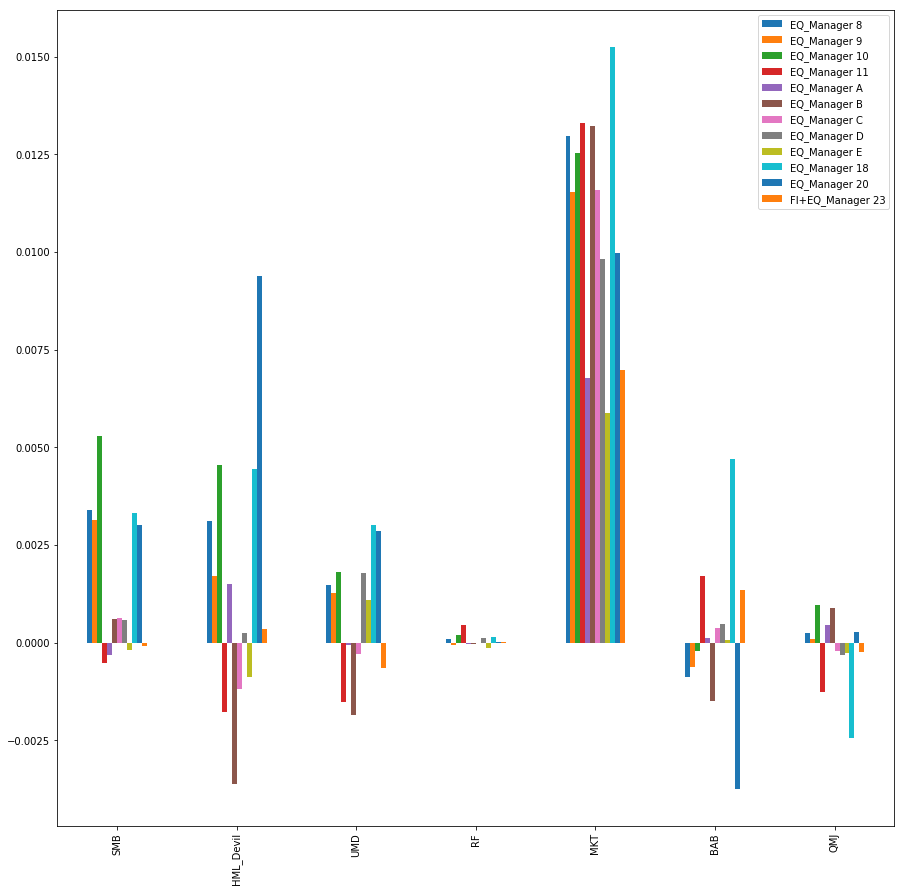

In [291]:
eq_T = eq_models_df.transpose()
eq_T.plot.bar(figsize=(15,15))

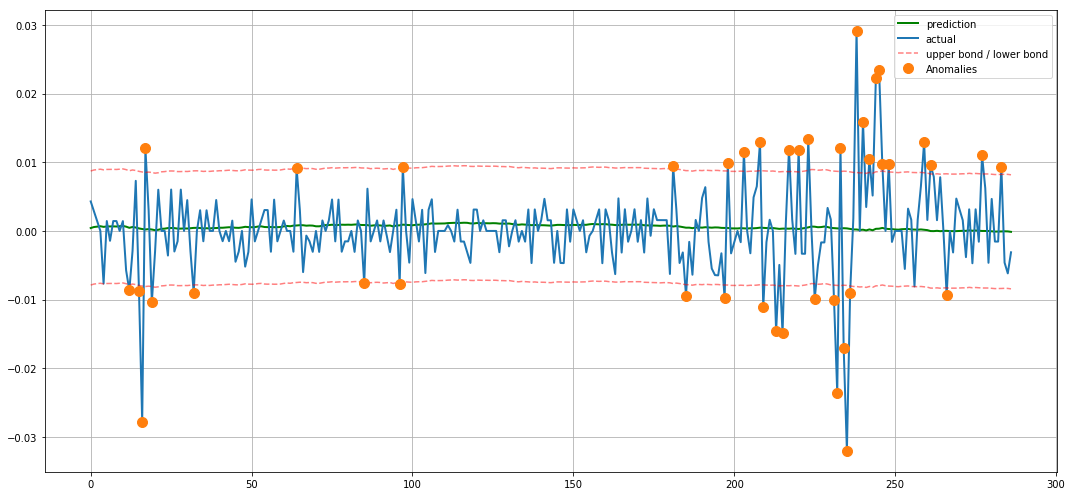

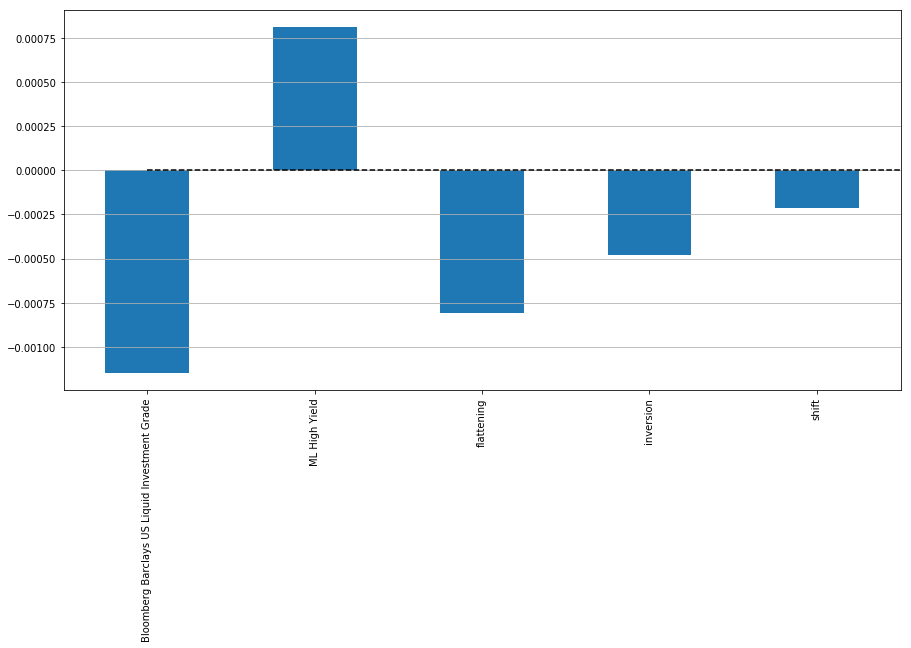

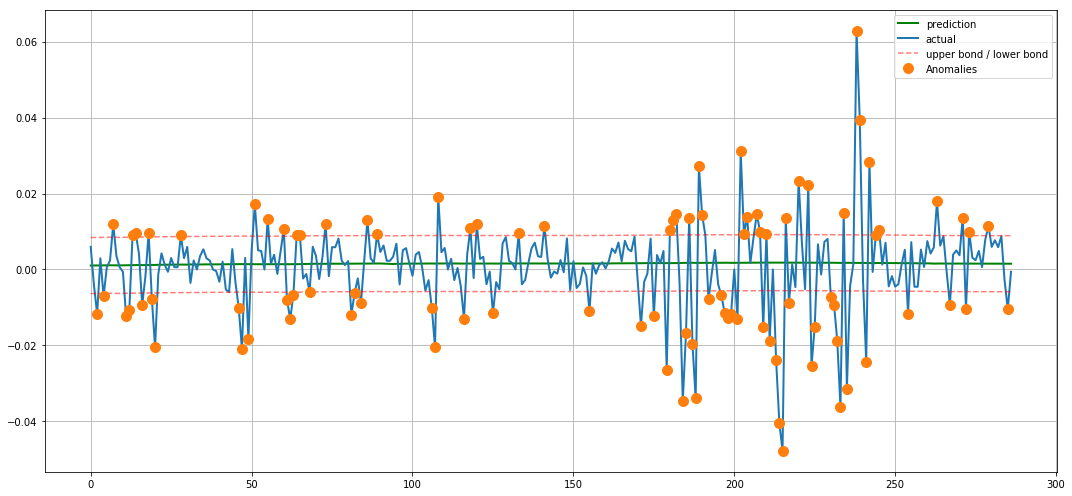

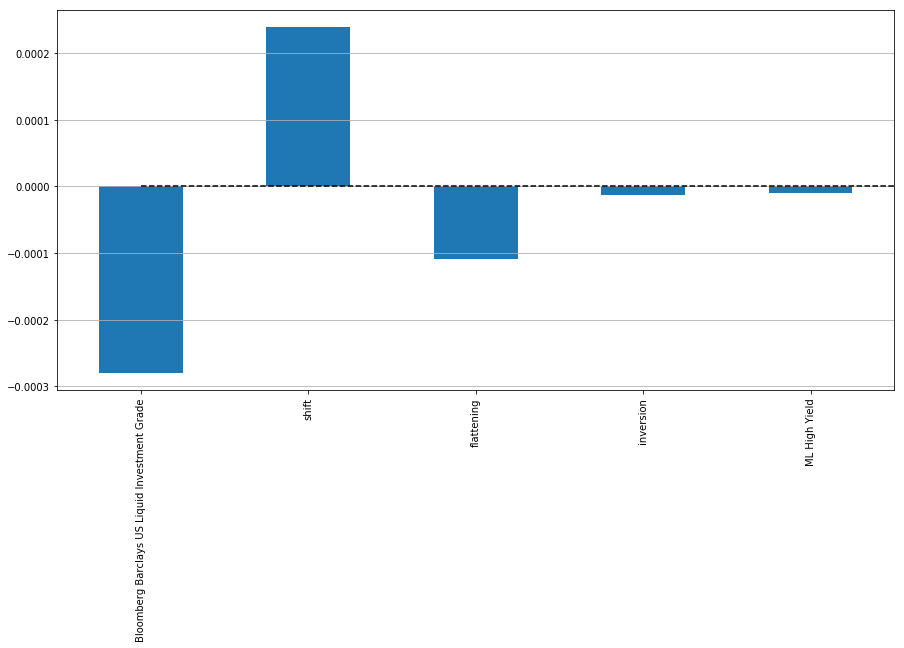

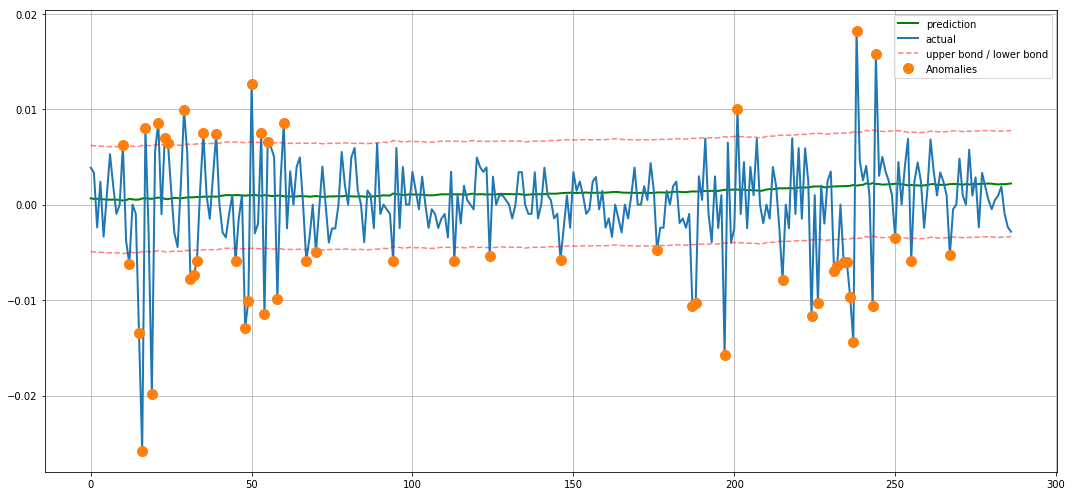

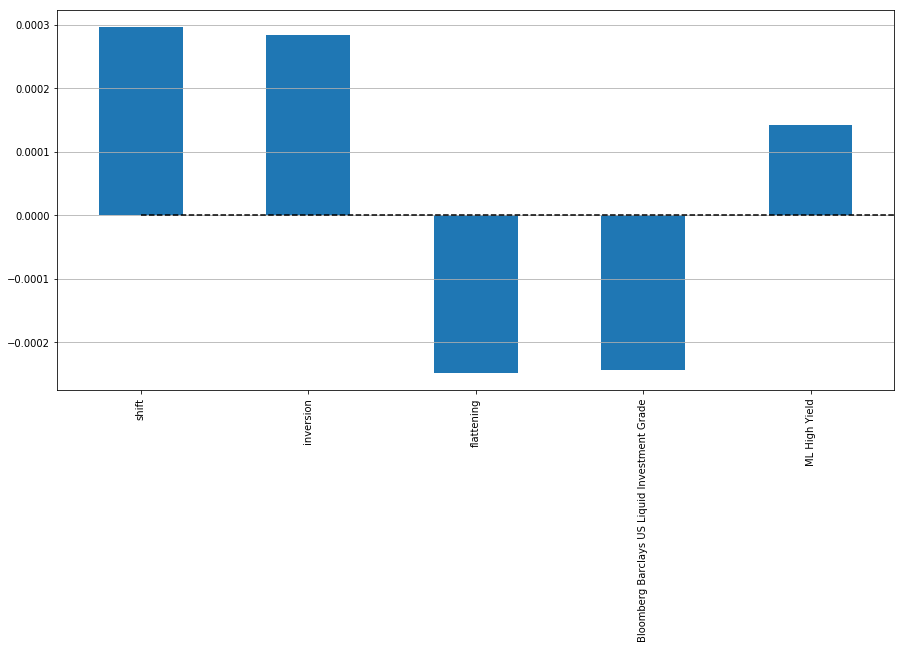

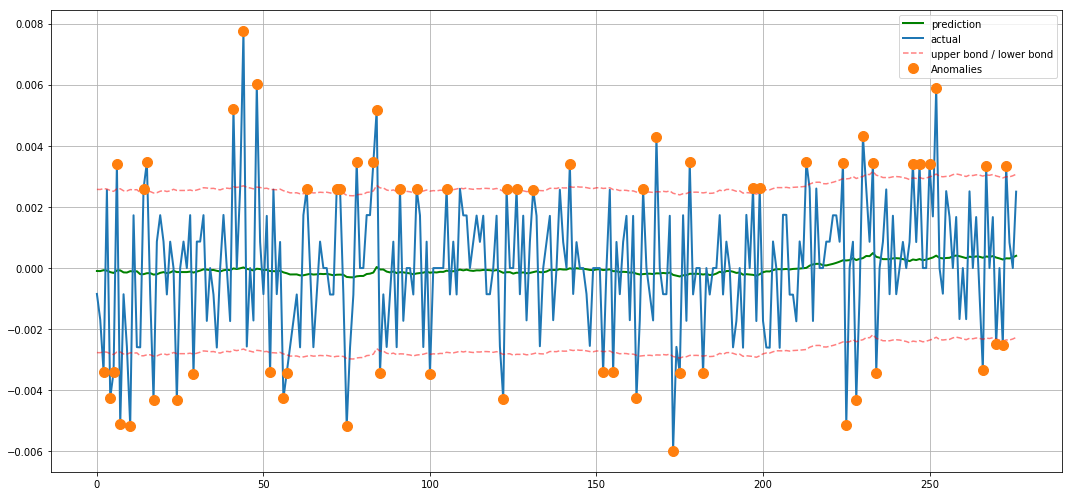

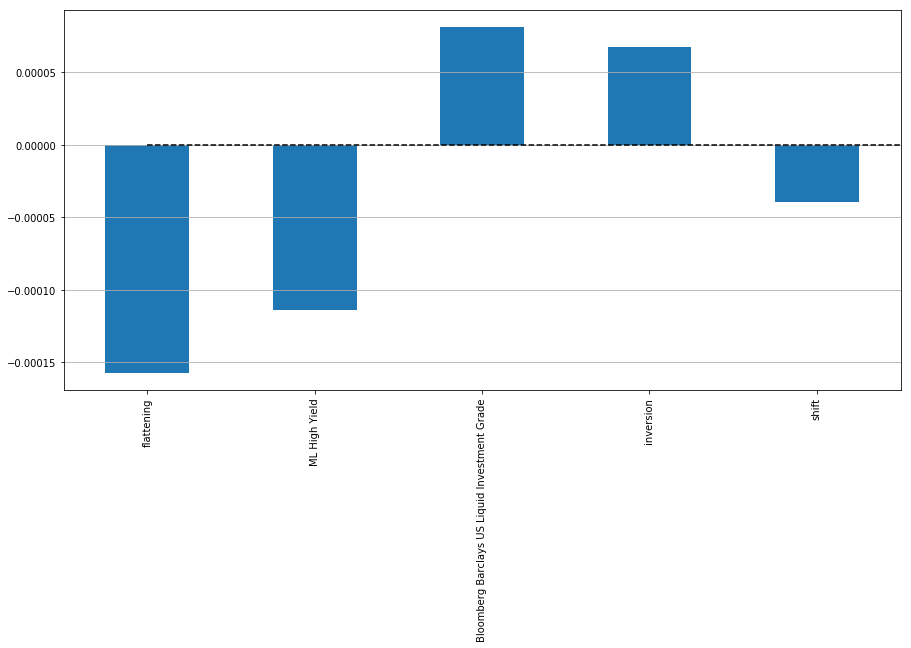

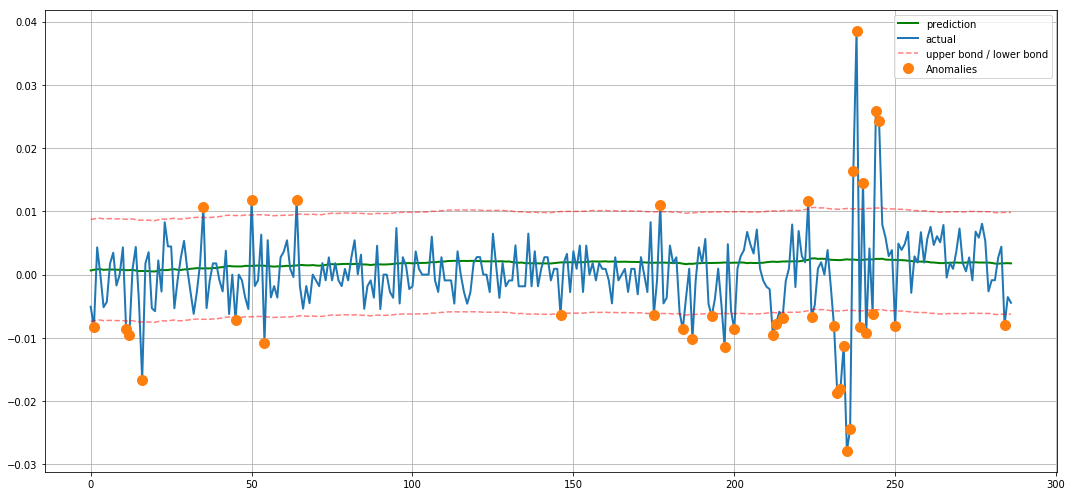

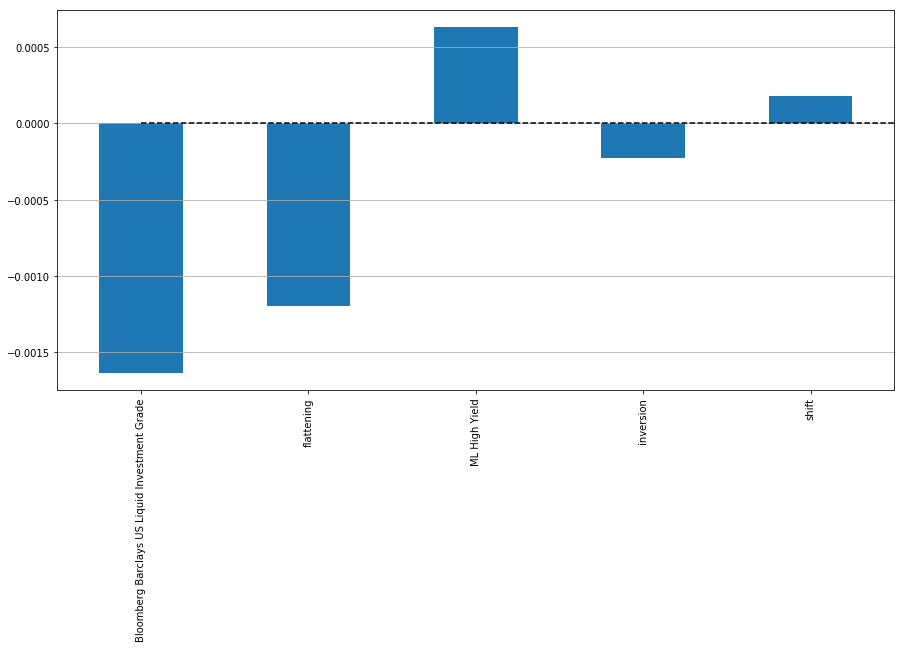

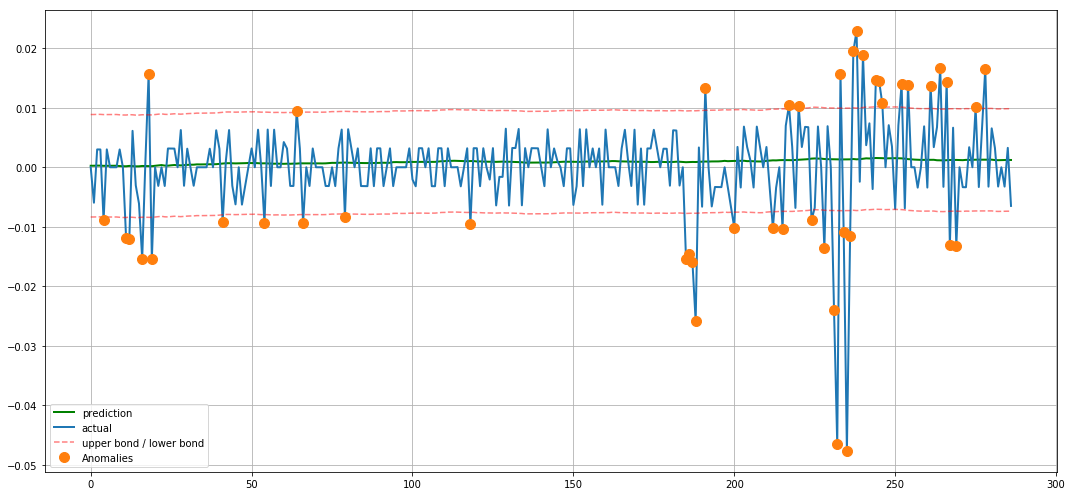

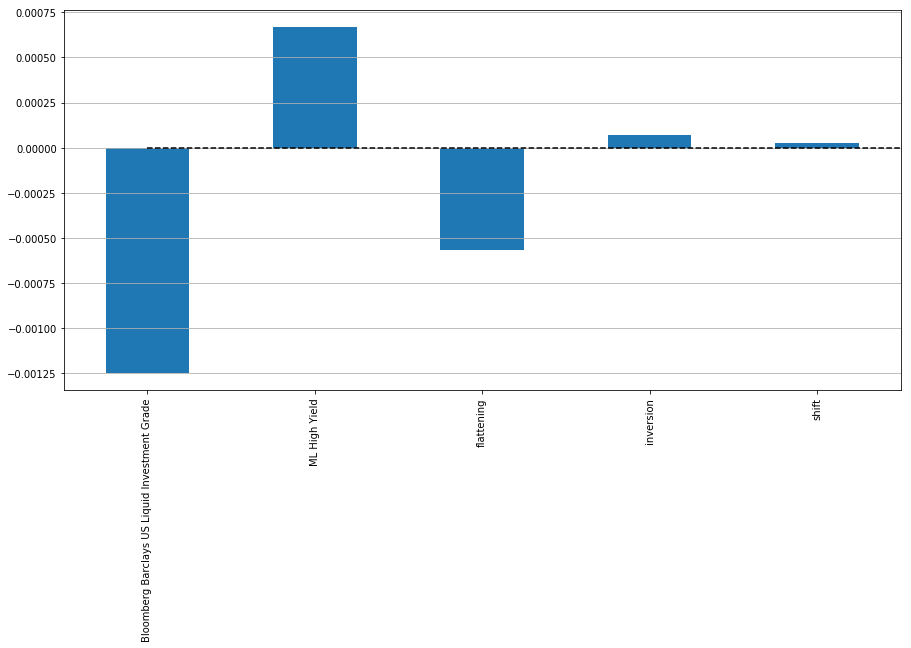

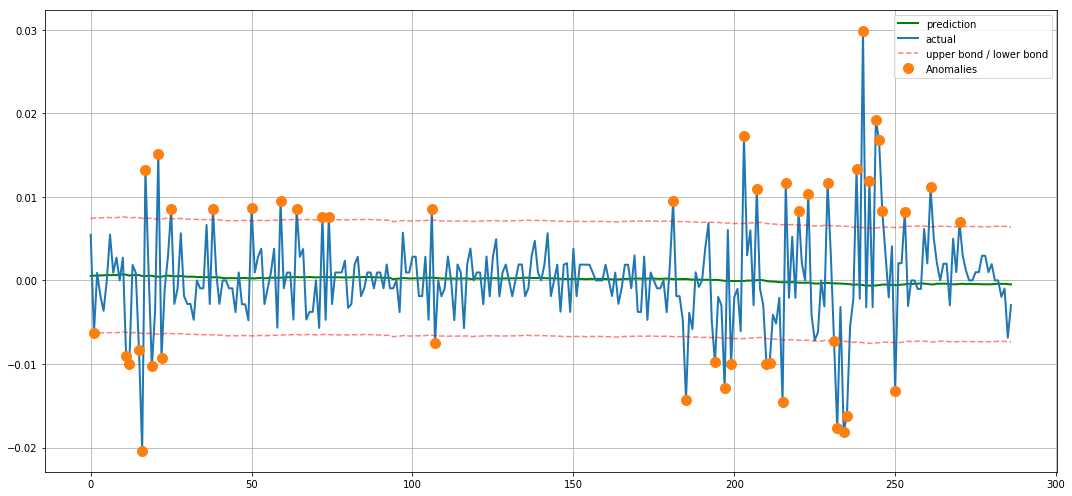

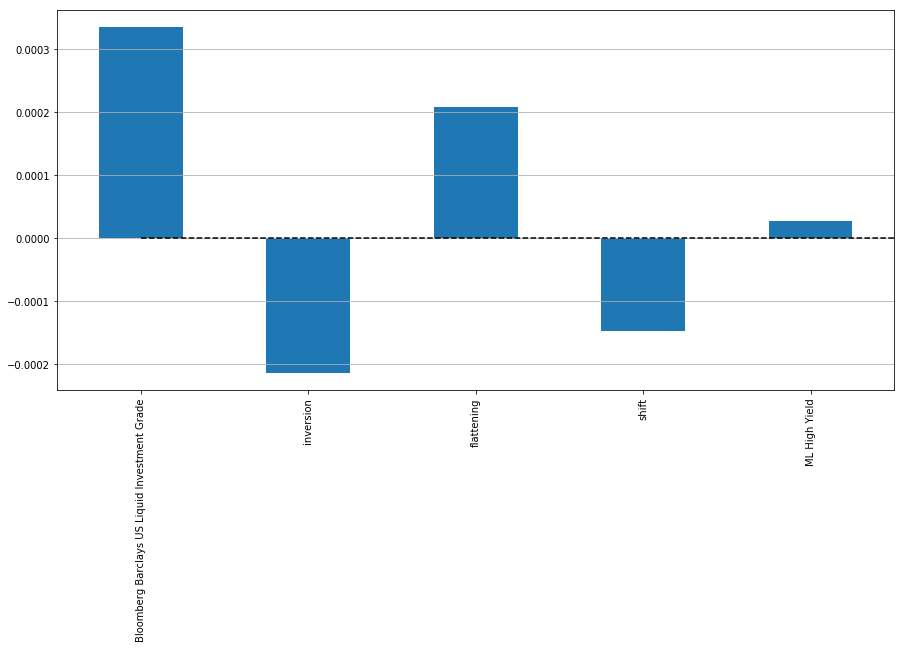

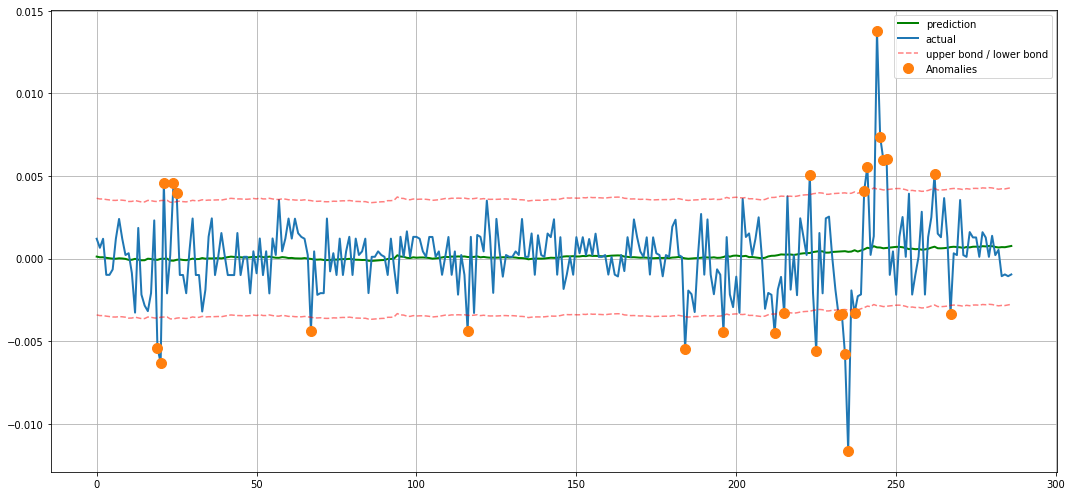

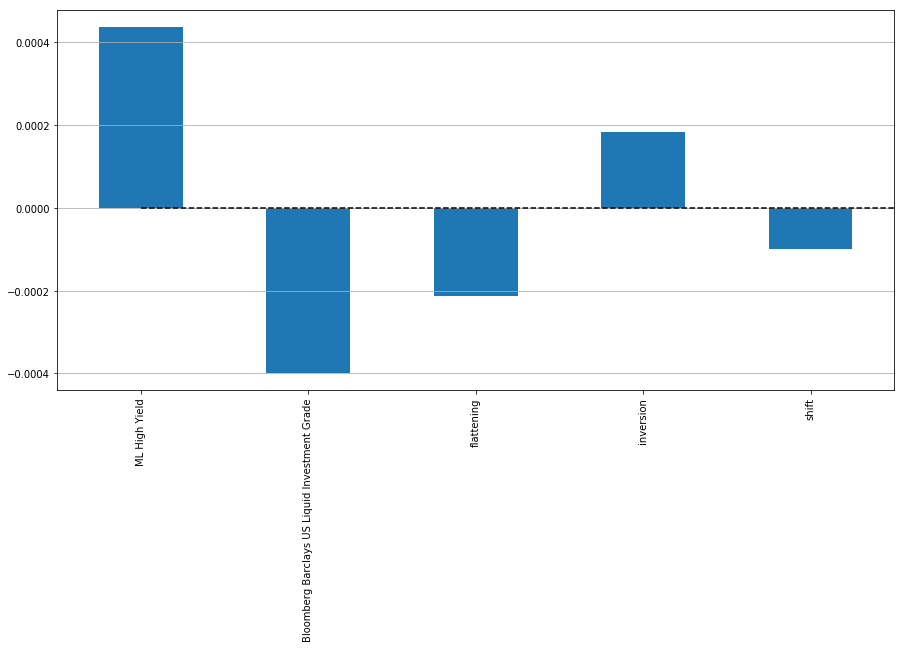

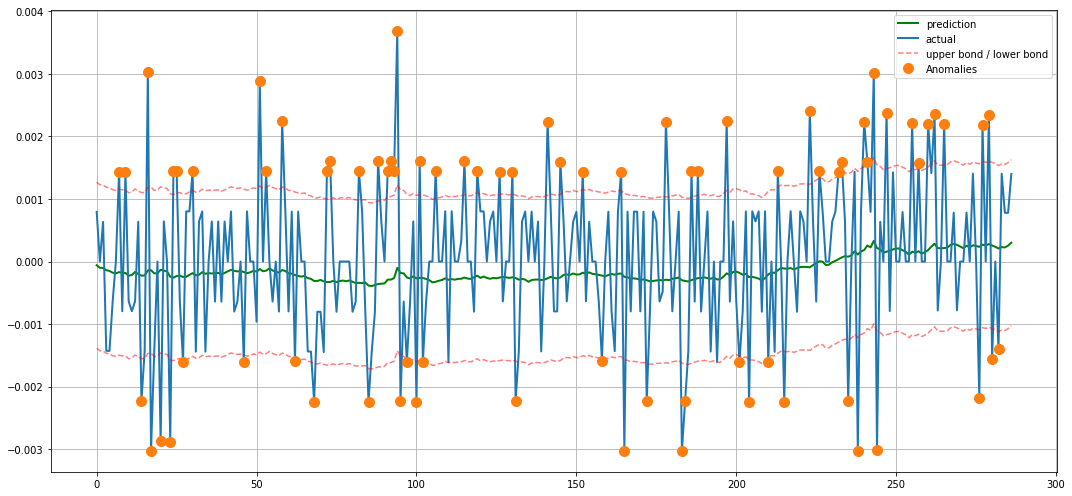

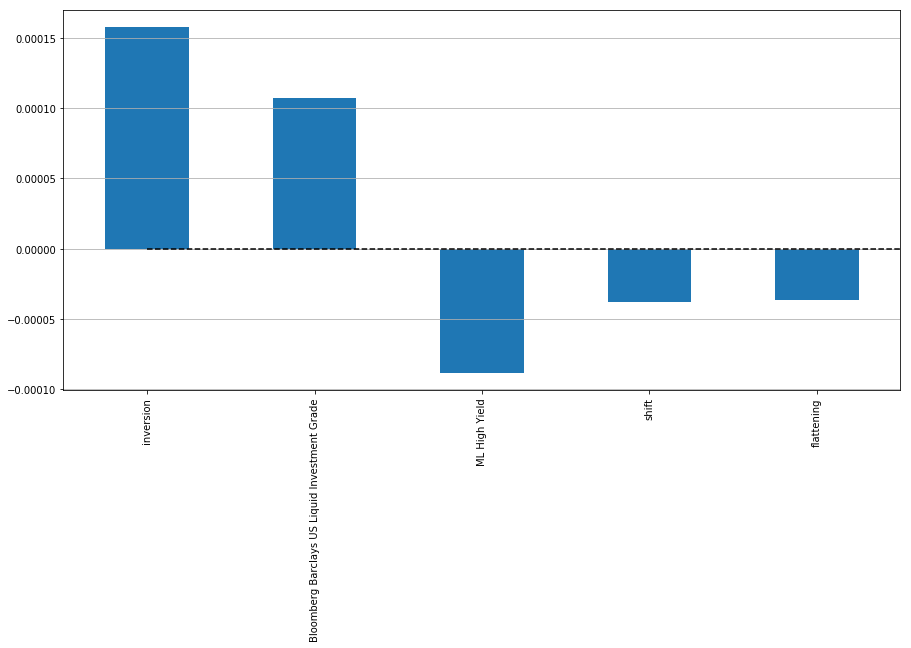

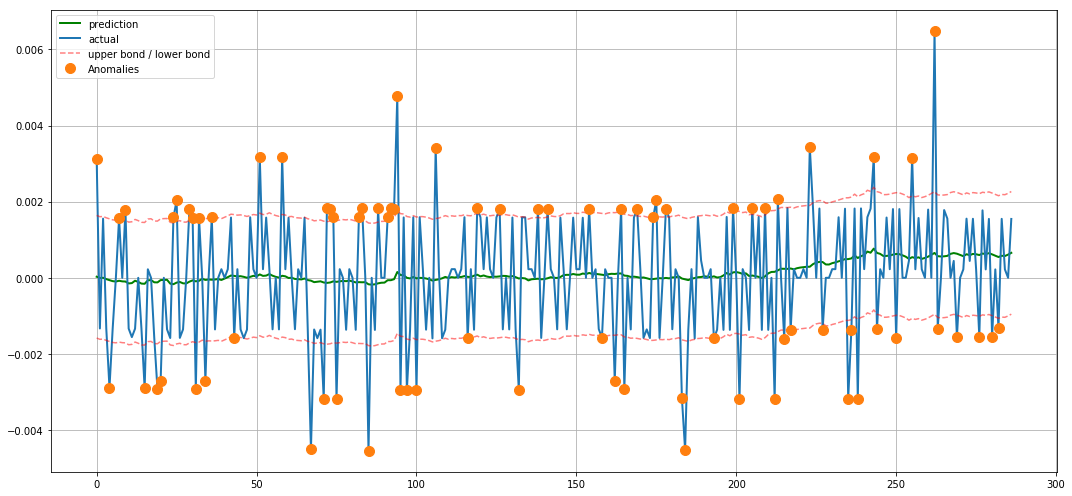

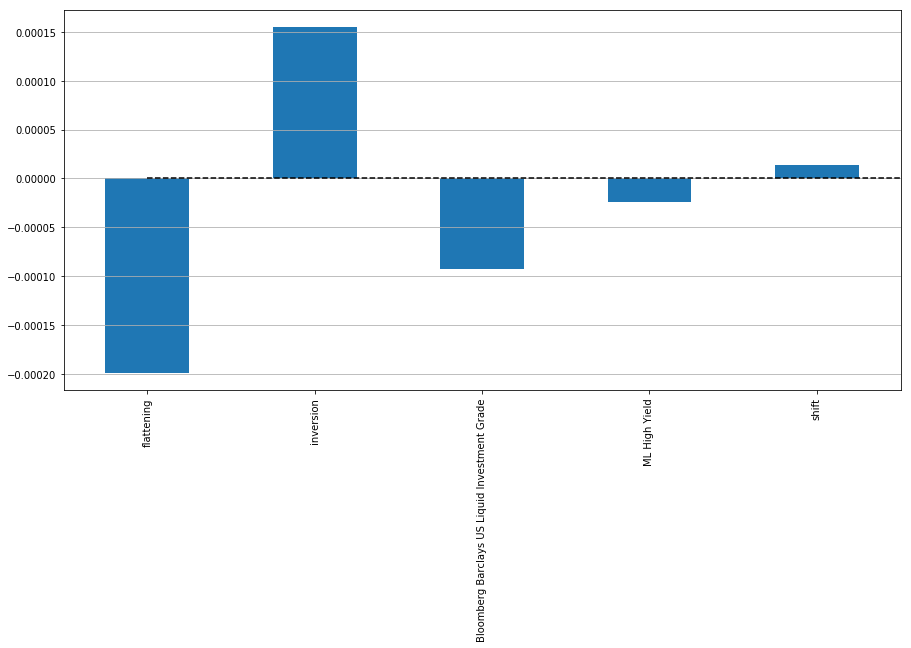

In [252]:
fi_data = pd.concat([fi_factors_PCA, fi_managers],1)
fi_models = []
test_size = 0.3
for y_col in fi_managers_cols: 
    x_cols = fi_factors_PCA.columns.to_list()
    x_cols.extend([y_col])
    data = fi_data[x_cols]
    fi_models.append(runRidgeCVonManager(data, y_col, test_size = test_size).coef_)

In [253]:
fi_models_df = pd.DataFrame(np.row_stack(fi_models))
fi_models_df.columns = fi_factors_PCA.columns.to_list()
fi_models_df.index = fi_managers_cols
fi_models_df.head()

Bloomberg Barclays US Liquid Investment Grade  \
FI_Manager 21                                         -0.001148   
FI_Manager 22                                         -0.000280   
FI+EQ_Manager 23                                      -0.000244   
FI_Manager 24                                          0.000081   
FI_Manager F                                          -0.001636   

                  ML High Yield     shift  flattening  inversion  
FI_Manager 21          0.000811 -0.000216   -0.000808  -0.000478  
FI_Manager 22         -0.000011  0.000239   -0.000109  -0.000013  
FI+EQ_Manager 23       0.000142  0.000296   -0.000249   0.000283  
FI_Manager 24         -0.000114 -0.000040   -0.000157   0.000067  
FI_Manager F           0.000631  0.000181   -0.001196  -0.000228

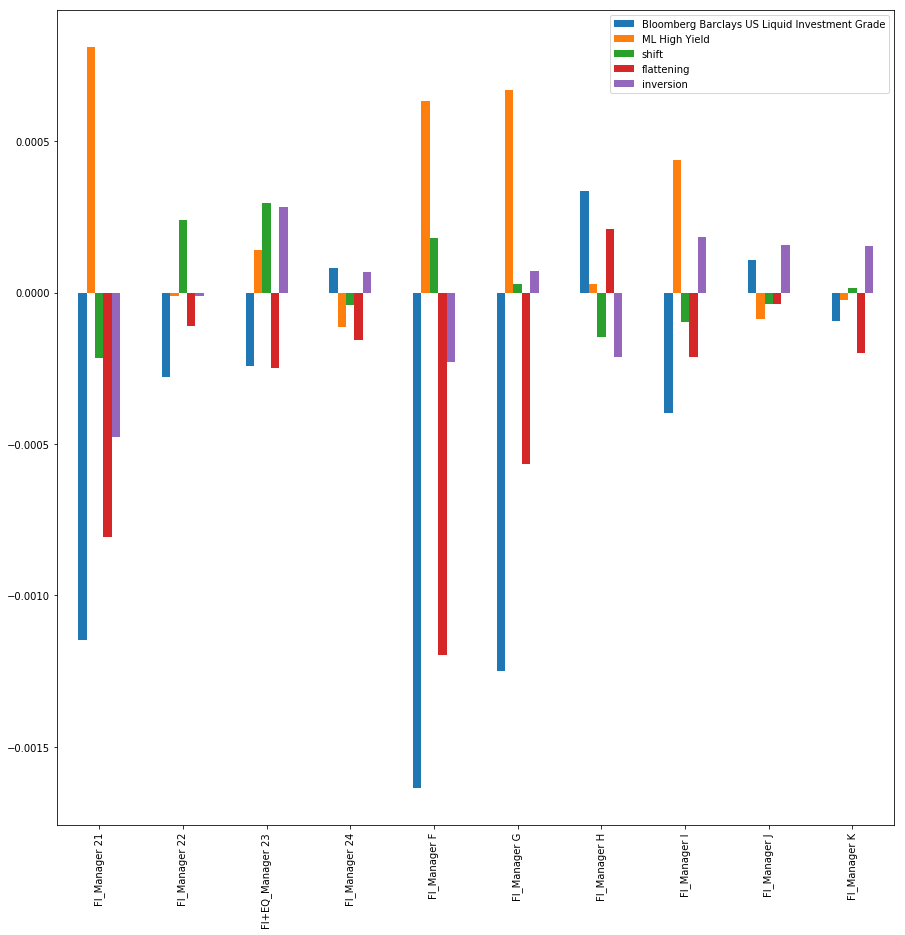

In [254]:
fi_models_df.plot.bar(figsize=(15,15))

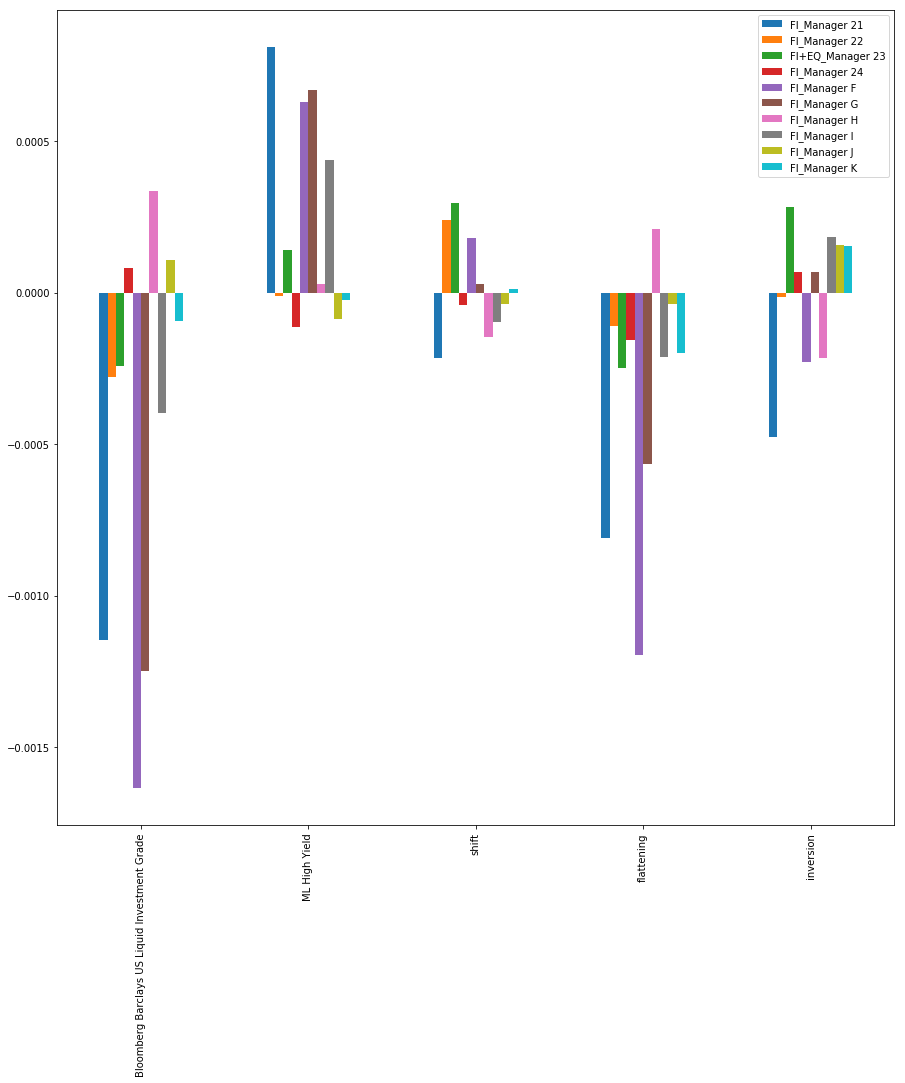

In [290]:
fi_T = fi_models_df.transpose()
fi_T.plot.bar(figsize=(15,15))

FI_Manager 21
FI_Manager 22
FI+EQ_Manager 23
FI_Manager 24
FI_Manager F
FI_Manager G
FI_Manager H
FI_Manager I
FI_Manager J
FI_Manager K


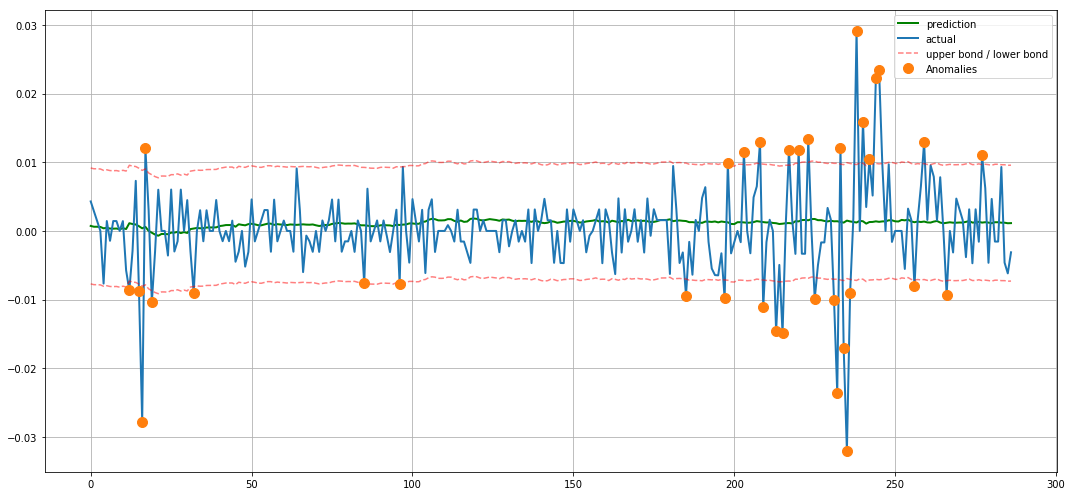

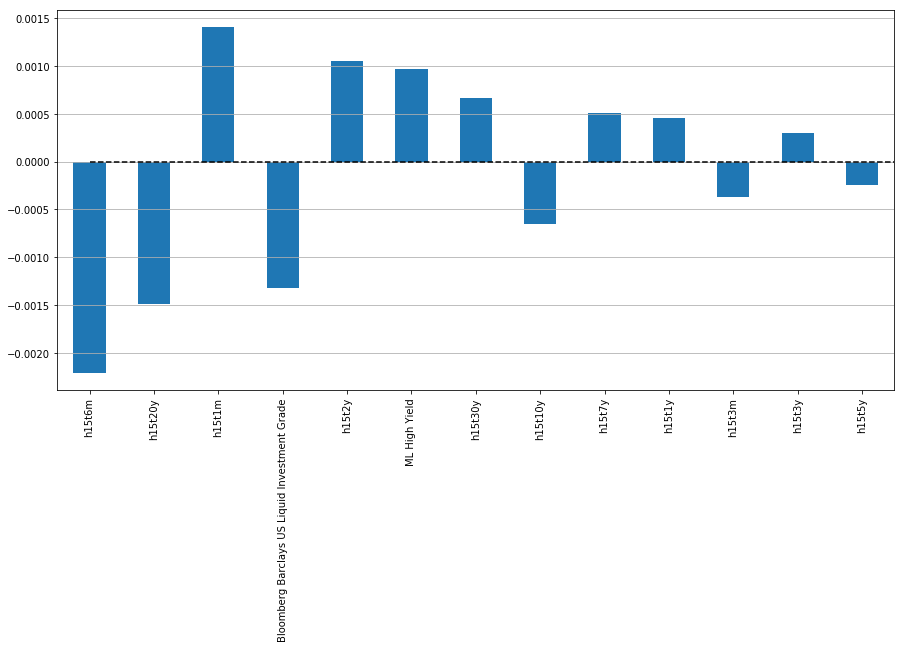

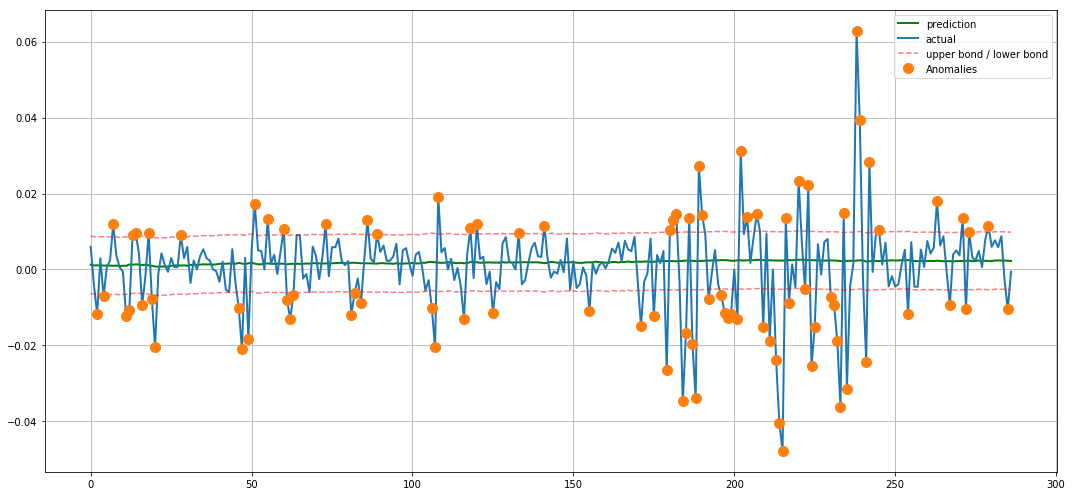

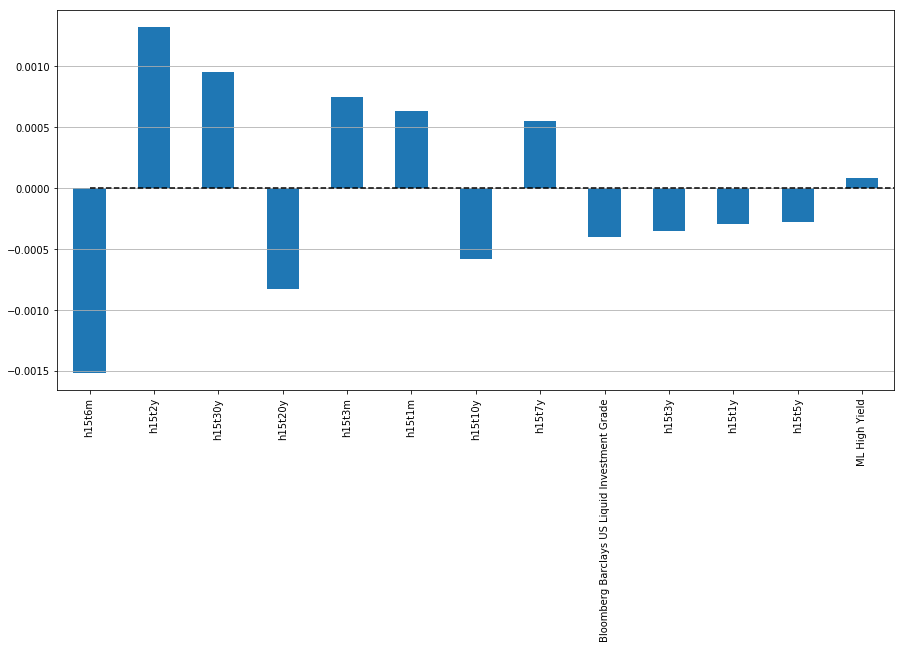

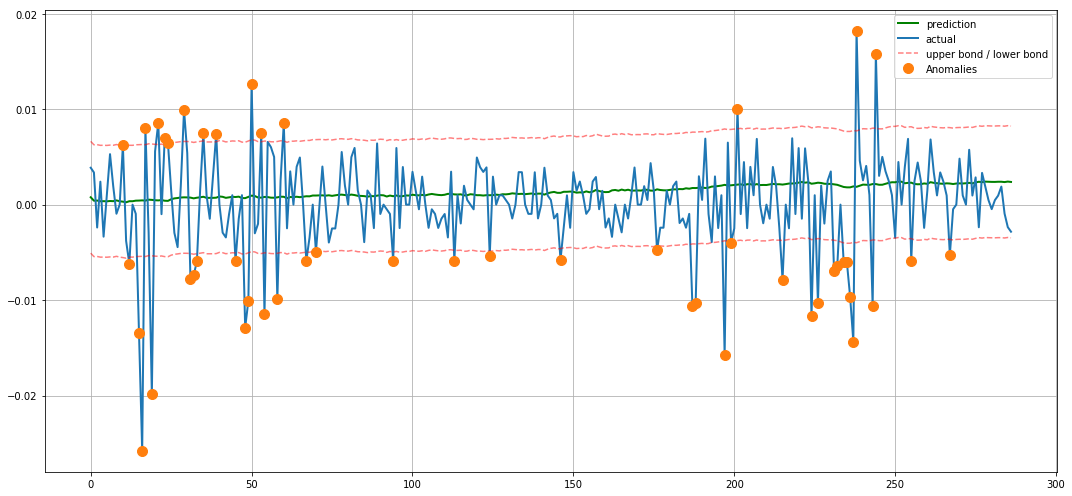

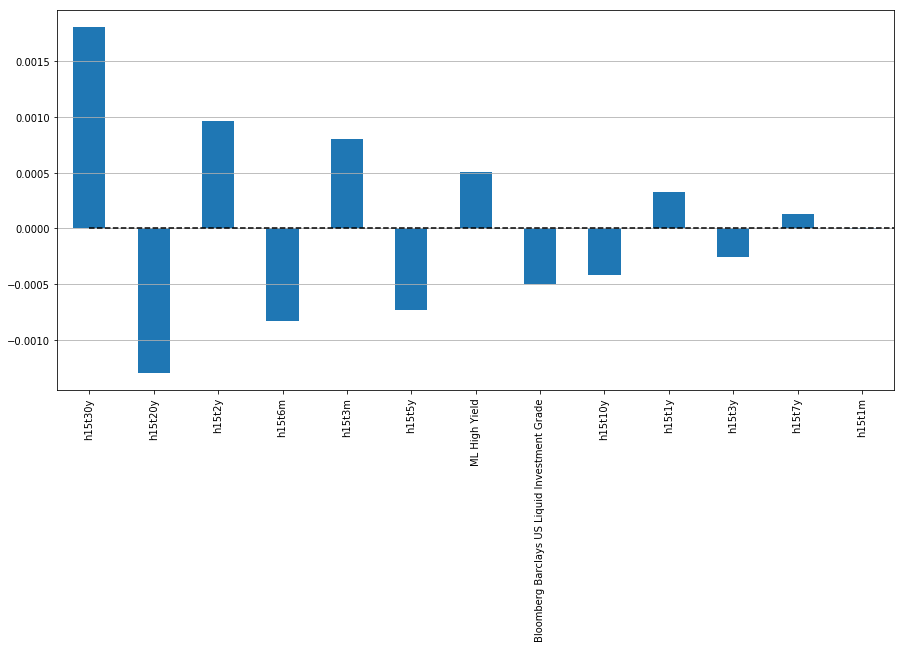

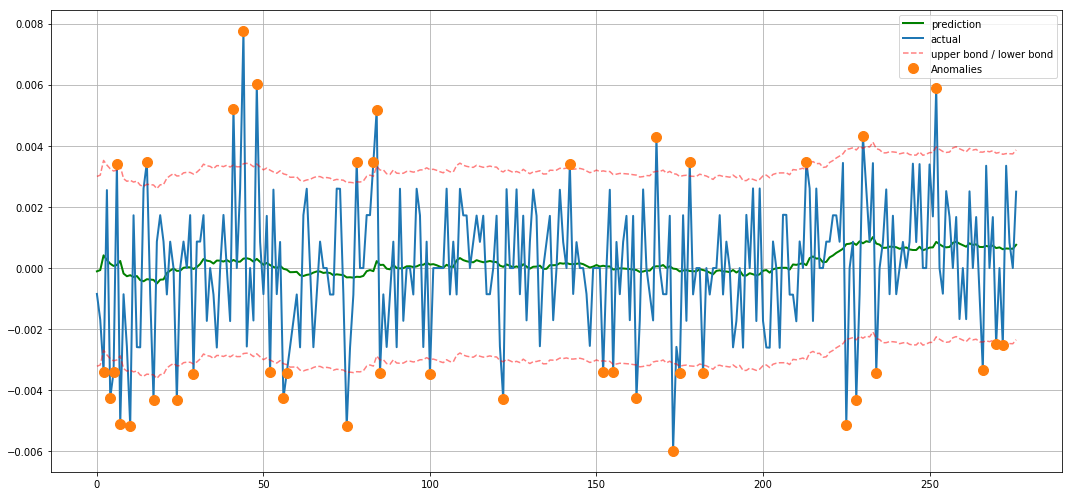

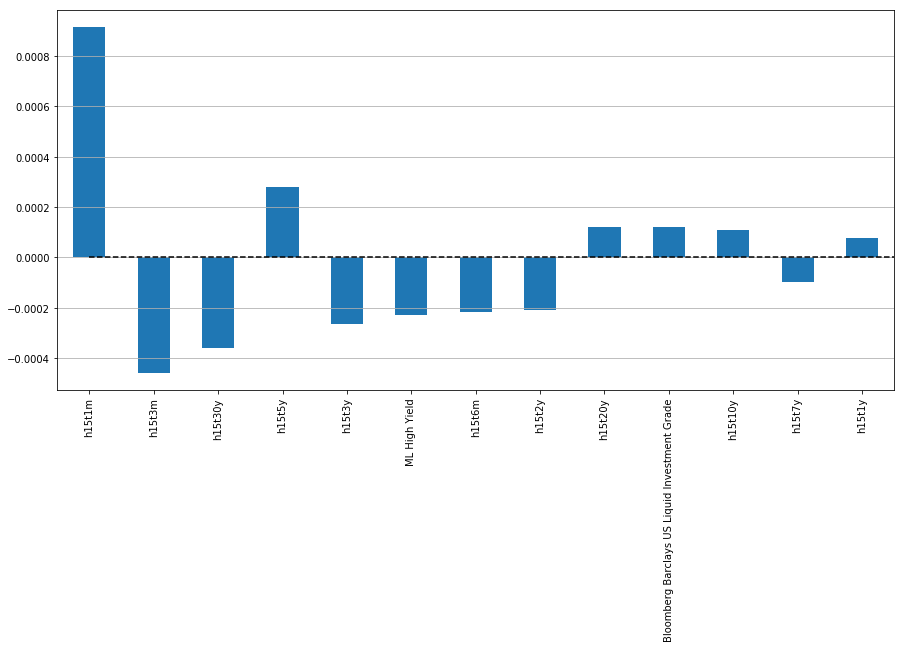

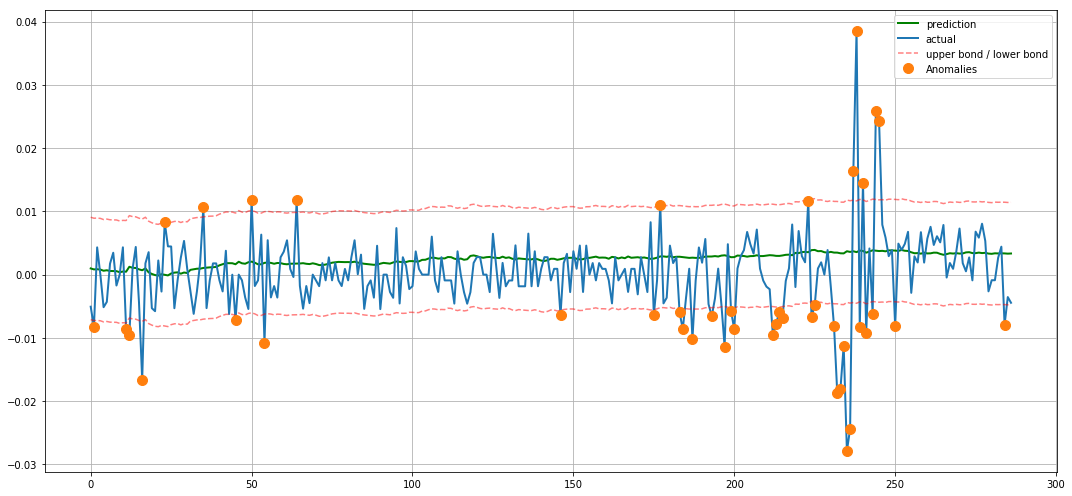

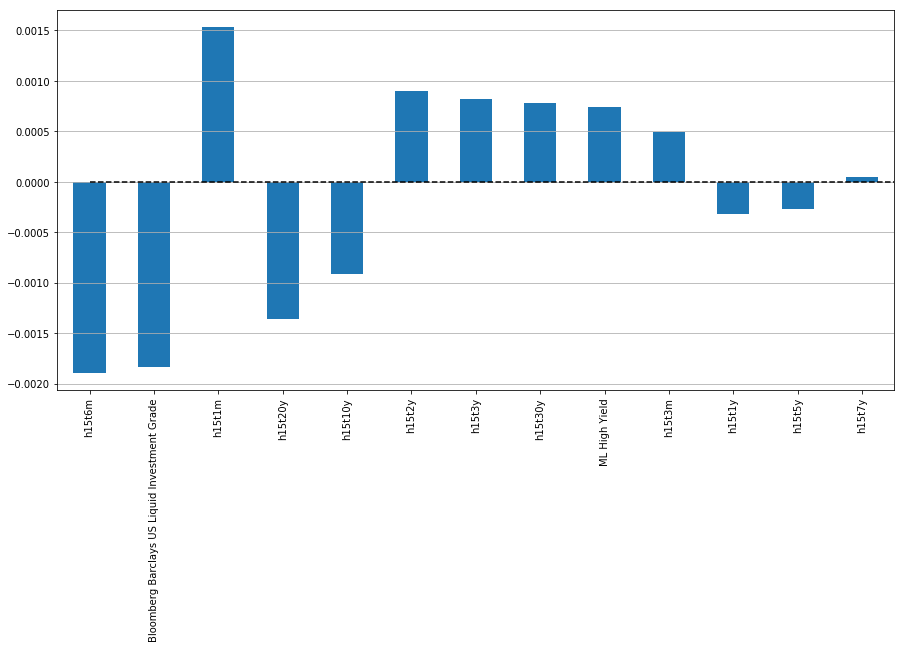

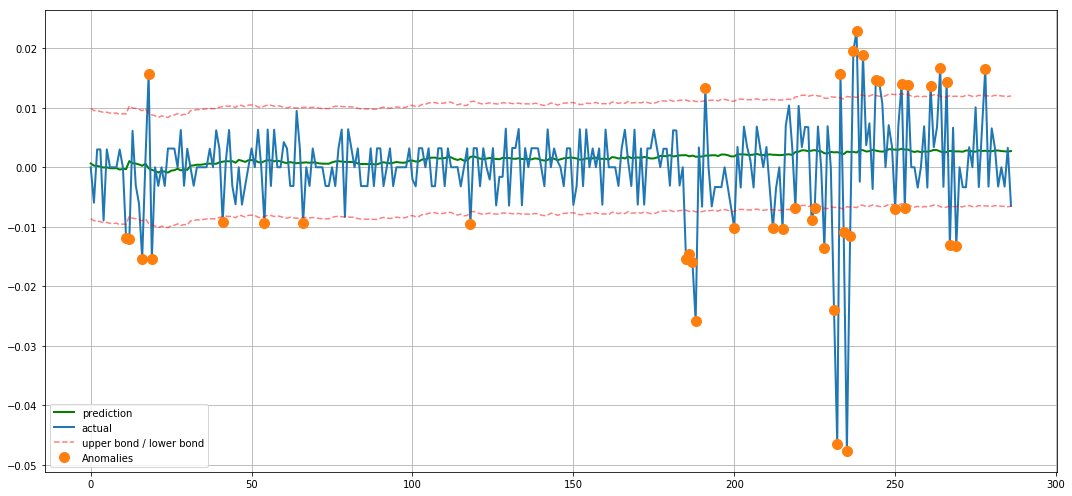

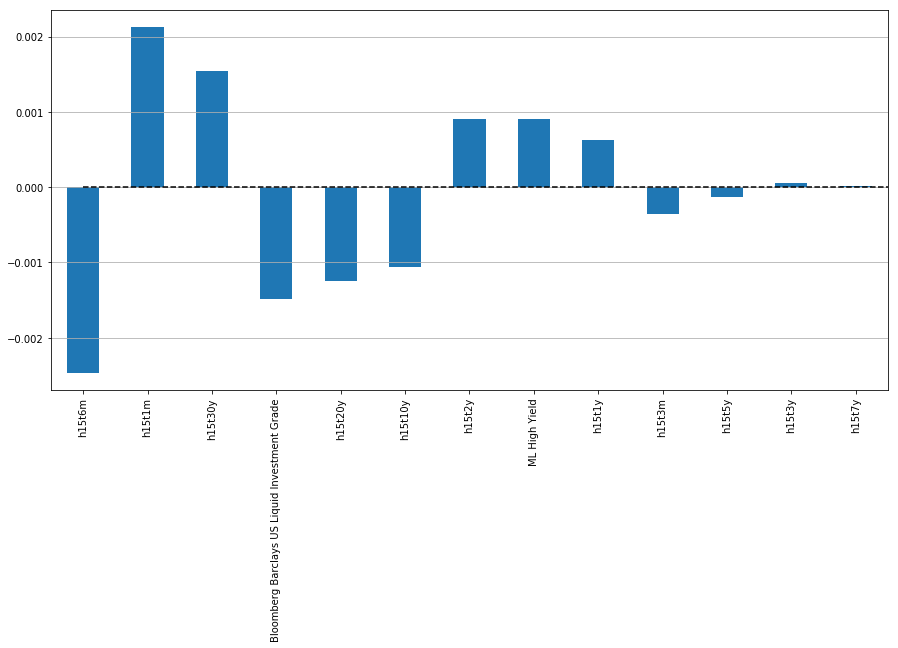

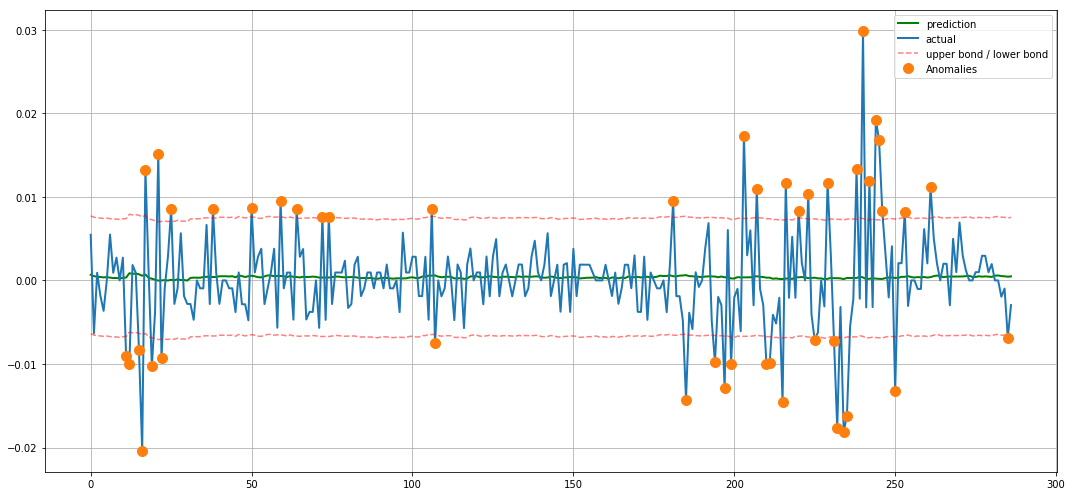

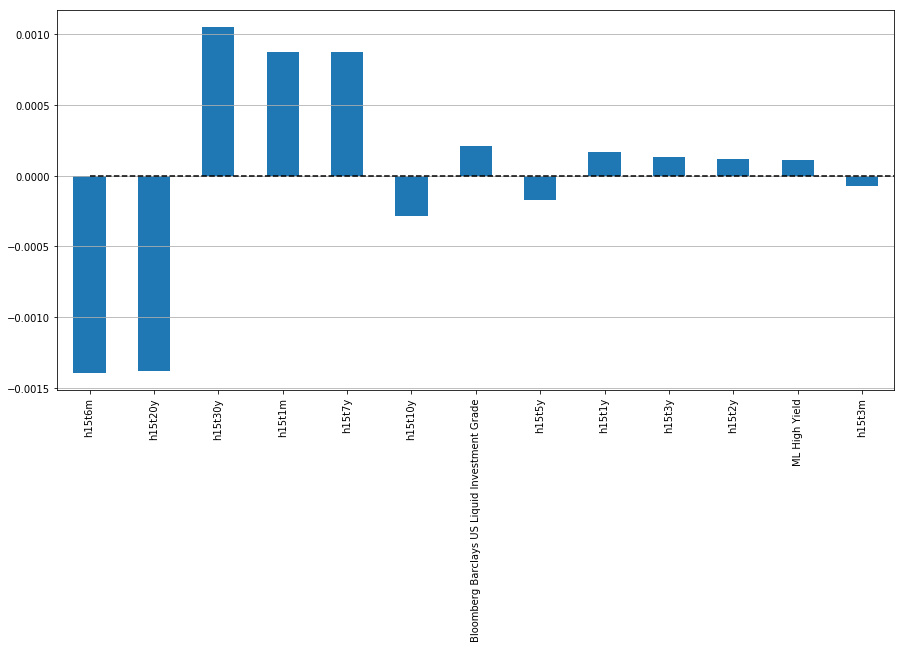

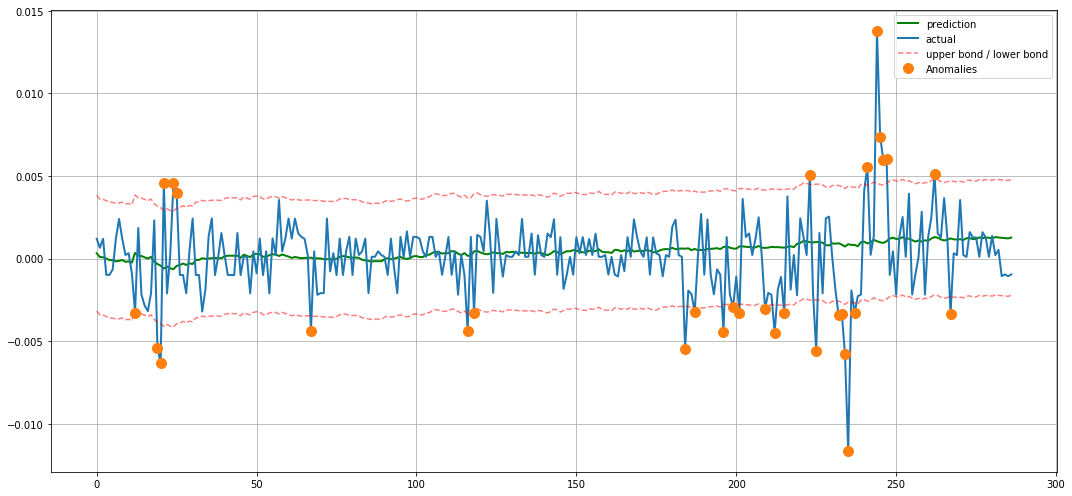

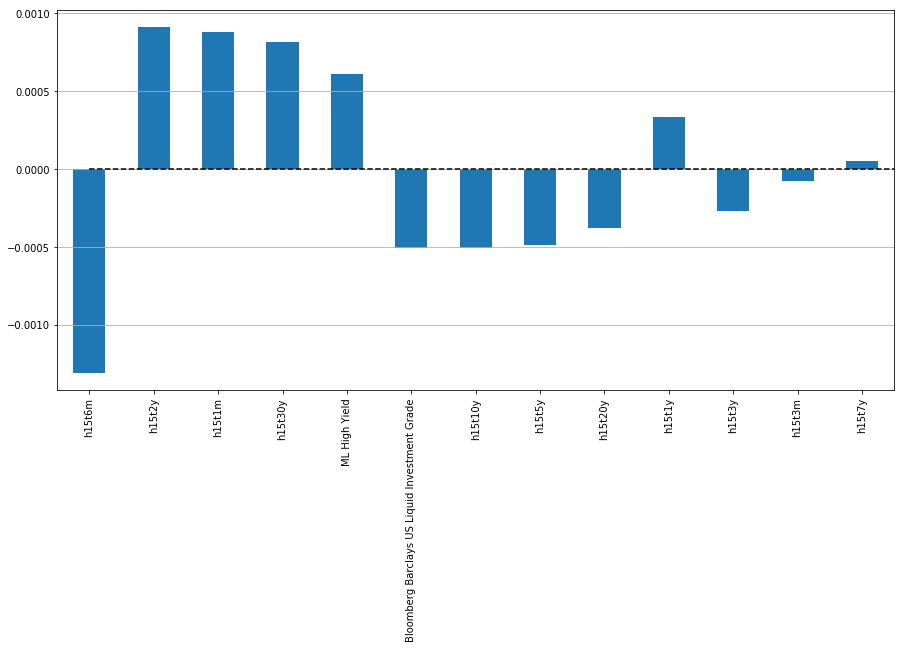

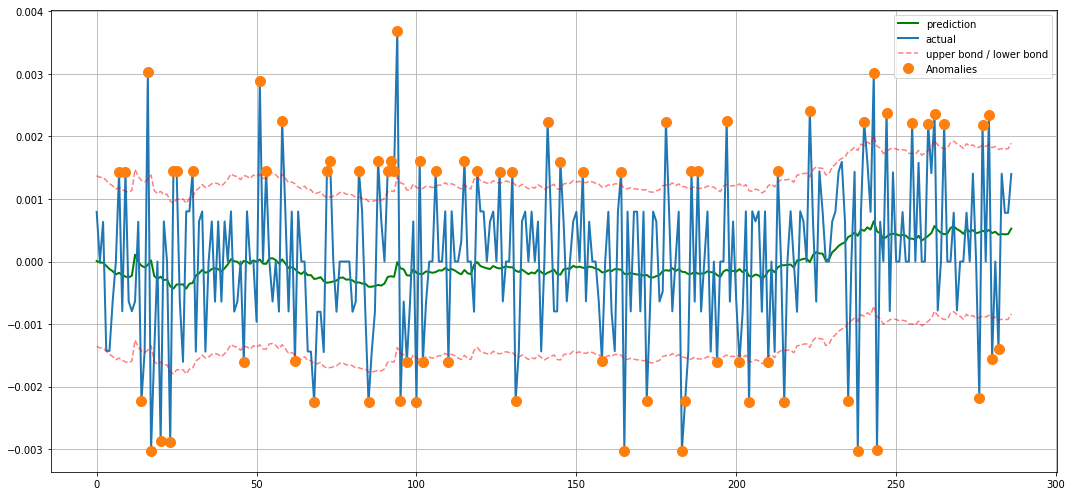

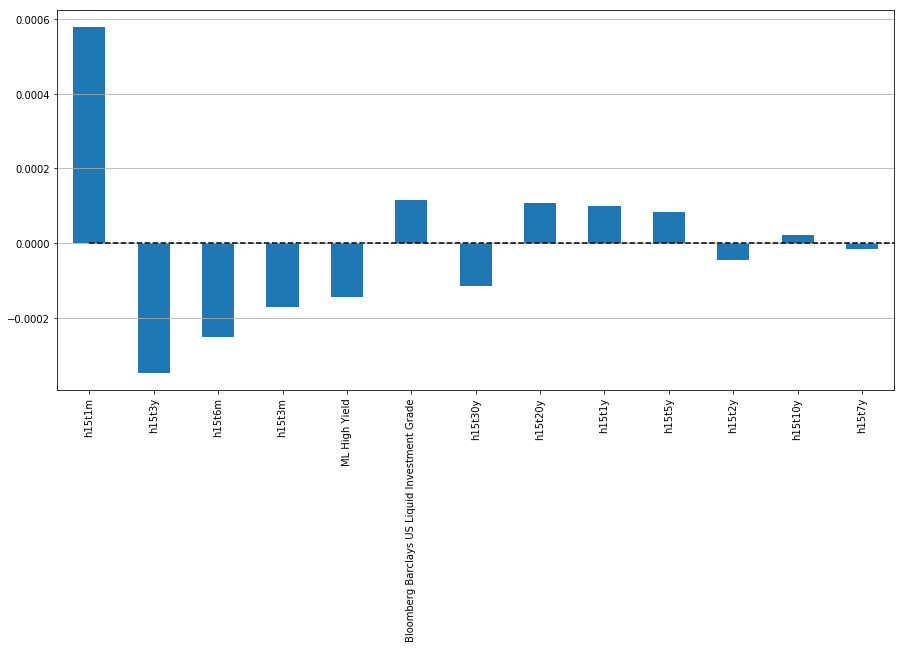

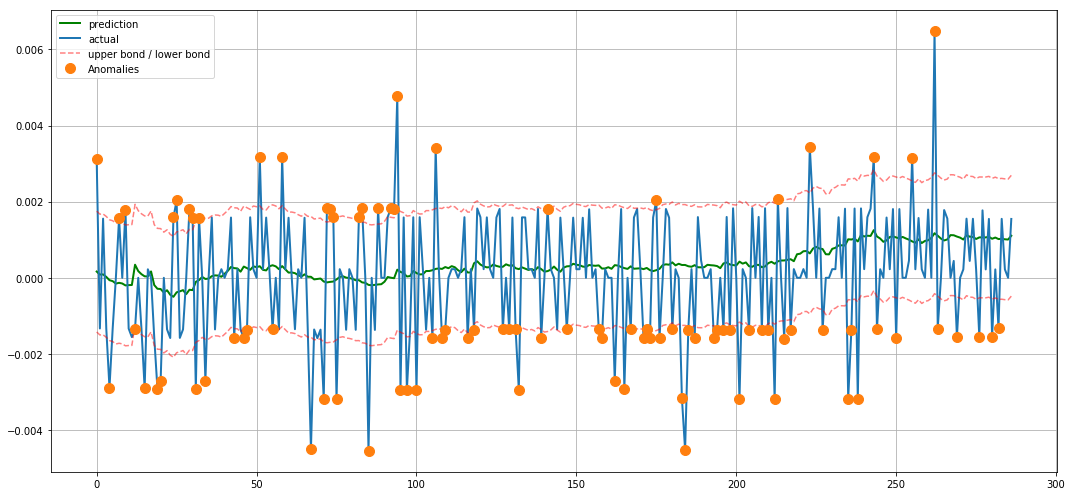

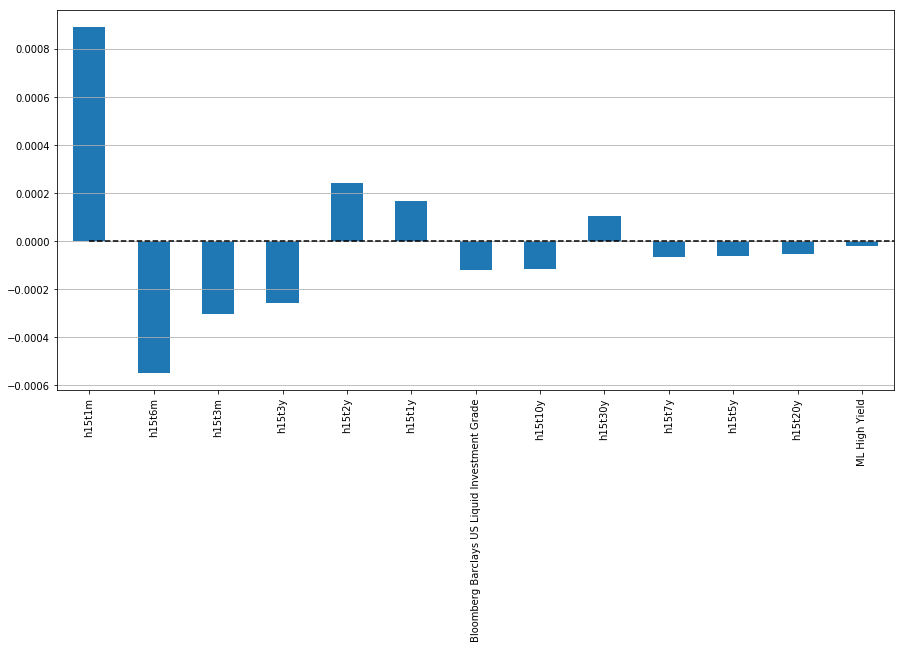

In [284]:
#lets see how non PCA version performs for FI 
fi_data_nonPCA = pd.concat([fi_factors_nonPCA, fi_managers],1)
fi_models_nonPCA = []
test_size = 0.3
for y_col in fi_managers_cols: 
    x_cols = fi_factors_nonPCA.columns.to_list()
    x_cols.extend([y_col])
    data = fi_data_nonPCA[x_cols]
    fi_models_nonPCA.append(runRidgeCVonManager(data, y_col, test_size = test_size).coef_)


In [285]:
fi_models_df_nonPCA = pd.DataFrame(np.row_stack(fi_models_nonPCA))
fi_models_df_nonPCA.columns = fi_factors_nonPCA.columns.to_list()
fi_models_df_nonPCA.index = fi_managers_cols
fi_models_df_nonPCA.head()

Bloomberg Barclays US Liquid Investment Grade  \
FI_Manager 21                                         -0.001327   
FI_Manager 22                                         -0.000404   
FI+EQ_Manager 23                                      -0.000499   
FI_Manager 24                                          0.000120   
FI_Manager F                                          -0.001836   

                  ML High Yield    h15t1m    h15t3m    h15t6m    h15t1y  \
FI_Manager 21          0.000969  0.001406 -0.000366 -0.002212  0.000457   
FI_Manager 22          0.000085  0.000630  0.000749 -0.001520 -0.000300   
FI+EQ_Manager 23       0.000503 -0.000004  0.000799 -0.000831  0.000323   
FI_Manager 24         -0.000228  0.000913 -0.000458 -0.000218  0.000077   
FI_Manager F           0.000739  0.001530  0.000496 -0.001896 -0.000323   

                    h15t2y    h15t3y    h15t5y    h15t7y   h15t10y   h15t20y  \
FI_Manager 21     0.001047  0.000294 -0.000248  0.000503 -0.000650 -0.001489   
FI_Manager 22     0.001323 -0.000355 -0.000282  0.000555 -0.000581 -0.000832   
FI+EQ_Manager 23  0.000963 -0.000252 -0.000730  0.000131 -0.000415 -0.001296   
FI_Manager 24    -0.000208 -0.000264  0.000279 -0.000098  0.000108  0.000122   
FI_Manager F      0.000898  0.000821 -0.000268  0.000045 -0.000912 -0.001358   

                   h15t30y  
FI_Manager 21     0.000661  
FI_Manager 22     0.000954  
FI+EQ_Manager 23  0.001804  
FI_Manager 24    -0.000361  
FI_Manager F      0.000779

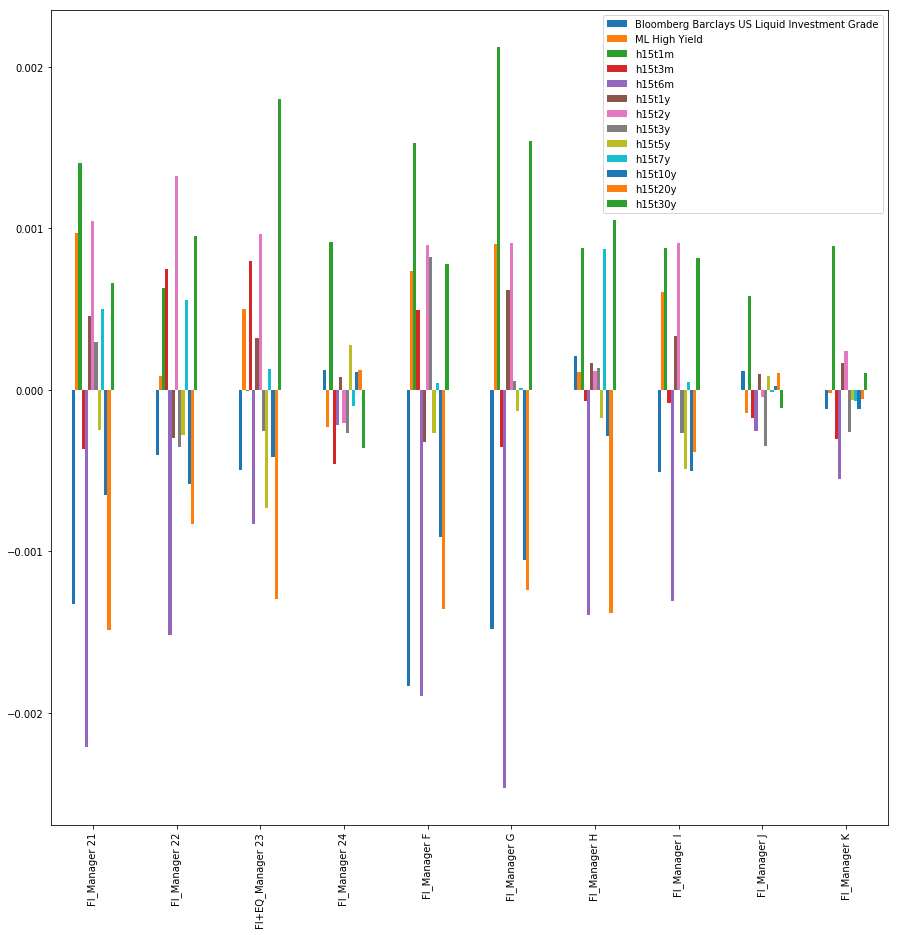

In [288]:
fi_models_df_nonPCA.plot.bar(figsize=(15,15))

### Fixed Income Factor Significance
Below plot what factors and in what magnitude contribute to the performance of  Fixed Income Managers. As, we can see most significant positive factor is the h15t1m and most significant negative factor is h15t6m.

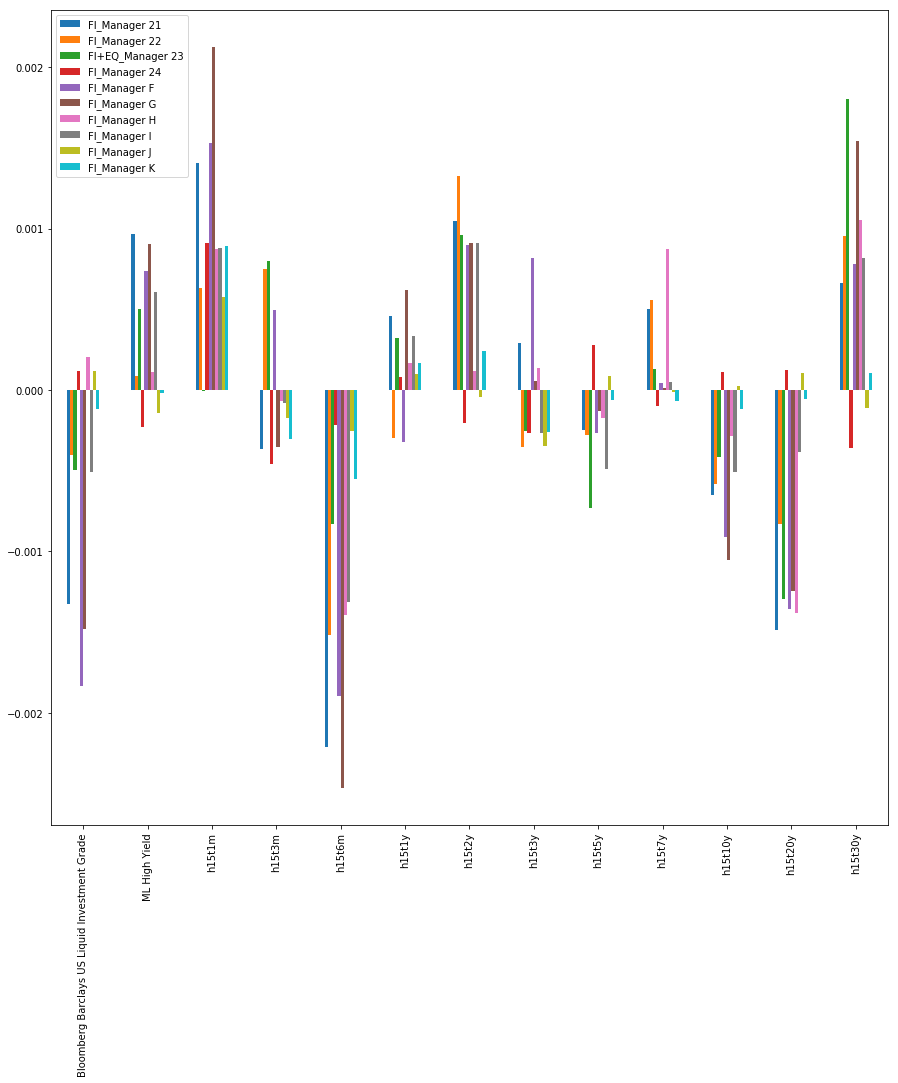

In [289]:
fi_nonPCA_T = fi_models_df_nonPCA.transpose()
fi_nonPCA_T.plot.bar(figsize=(15,15))